# **Deep learning tutorial** [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TomGeorge1234/DeepLearningTutorial/blob/main/deeplearning.ipynb)
### **TReND Computational Neuroscience and Machine Learning Summer School**
#### made by: **Tom George, UCL**

In this tutorial we will get hands on building deep neural networks and training them via backproagation. Initially the goal is to **avoid autograd packages**, such as `pytorch` or `jax` at all costs. Coding a deep neural network by hand this way will help us gain an understanding of the mathematics going on behind the scenes. At the end we will use `pytorch` to build a much deeper network and see how it performs. Here's the plan:


## **Learning Objectives**

0. **Set-up**: Generate some data for a neuroscience-inspired task our networks will try to learn
1. **Linear regression**: A simple model with an analytic solution. We'll use this as a comparison later on.
2. **Gradient descent** :An algorithm for training complex models
2. **Deep neural networks (by hand)**: Derive the learning rules for a deep neural network with two hidden layers and code this by hand.
3. **Deep neural networks (by `pytorch`)**: Using an autograd package to show how these models can be scaled efficiently.

<center><img src="https://github.com/TomGeorge1234/DeepLearningTutorial/blob/main/figs/illusion_of_dl.gif?raw=1" width=1000></center>

## **Contents**
0. [A neuro-inspired regression task](#task-setup)
    1. [Generating data](#generate-data)
    2. [Using data arrays](#data-arrays)
    3. [Training and testing splits](#train-test-split)
    4. [Visualising the data](#plot-data)
    5. [Making a `Model()` class](#model-class)
1. [Linear regression](#linear-regression)
    1. [Building a linear model in code](#build-linear-model)
    2. [Optimising linear models](#linear-regression-solution)
    3. [Performance](#linear-model-performance)
    4. [Interpretation](#interpretation)
2. [Gradient Descent](#gradient-descent)
    1. [In one-dimension](#1D-gradient-descent)
3. [Deep Neural Network (without autograd)](#DNNs)
    1. [Loss function](#DNN-loss)
    2. [Implementing the model (in python)](#DNN-python)
    3. [Non-linearities](#non-linearities)
    4. [Calculating the gradients](#DNN-gradients)
    5. [Stochastic batched gradient descent](#batched-gd)
    6. [Summary](#DNN-summary)
    7. [Implementing gradient descent (in python)](#DNN-gd-pythoncode)
    8. [Training](#DNN-training)
    9. [Recursive backpropagation (deeper and deeper...)](#recursive-backprop)
4. [Deep Neural Networks (with autograd using pytorch)](#)
    1. [What is autograd?](#autograd)
    2. [A friendly warning](#warning)
    3. [Implementing a DNN (in pytorch)](#pytorch-implementation)
    4. [Optimisers](#optimisers)
    5. [Visualising training over epochs](#visualising-learning)



--
## **0. A neuro-inspired regression task:** predicting position from neural firing rates <a name="task-setup"></a>

Since this is a summer school on computational neuroscience we will design a neuroscience inspired task to train our networks on. This task is:

**<center>To predict the location of an agent from the firing rate of a several place cells</center>**

For this we will use the `RatInABox` package.

The dataset (in machine learning notation $D = \{(\vec{x}^{(n)},\vec{y}^{(n)})\}_{n=1}^{N}$)  consists of tuples of inputs $\vec{x}^{(n)}$ and outputs ("targets") $\vec{y}^{(n)}$...
* $\vec{x}^{(n)} \in \mathbb{R}^{N_{\textrm{cells}}}$ is the vector of firing rates of all cells at the time corresponding to the $n^{\textrm{th}}$ training datapoint

\begin{equation} \vec{x}^{(n)}= \begin{bmatrix} f_1(t_n) \\ f_2(t_n) \\ ... \\ f_{N_{\textrm{cells}}}(t_n) \end{bmatrix} \end{equation}

* $\vec{y}^{(n)} \in \mathbb{R}^{2}$ is the position $[\mathsf{x},\mathsf{y}]^{\mathsf{T}}$ vector of the agent at the time corresponding to the $n^{\textrm{th}}$ training datapoint.

\begin{equation} \vec{y}^{(n)}= \begin{bmatrix} \mathsf{x}(t_n) \\ \mathsf{y}(t_n)  \end{bmatrix} \end{equation}

Note! Do confuse $\mathsf{x}(t_n)$ and $\mathsf{y}(t_n)$ (the x and y-positions at the n $^{th}$ timestep) with $x^{(n)}$ and $y^{(n)}$ (the n $^{th}$ inputs and outputs).

<center><img src="https://github.com/TomGeorge1234/DeepLearningTutorial/blob/main/figs/task_setup.png?raw=1" width=1000></center>

Let's go ahead and make the data...then this will start to make more sense. Before we do here are some other examples of regression problem

**Regression Examples:**
* Estimating the age of a person based on their height, weight, and other physical attributes.
* Predicting the response time of a subject in a behavioral experiment based on stimulus properties, task difficulty, and individual differences.

Classification tasks are like regression problems except the goal is to predict a discrete category from a set of inputs. The approachs we'll use today can be used for either regression or classification tasks.

**Classification task examples**
* Classifying Jollof as Ghanain or Nigerian based on a set of features (appearance, colour, smell, taste).
* Classifying handwritten digits as 0-9 based on pixel values.
* Classifying emails as spam or not-spam.

> **_📝TASK_** Write down three more examples of regression problems and three more examples of classification problems.

### **0.1 Generate data using `ratinabox`** <a name="generate-data"></a>

In [1]:
#@title INSTALL AND IMPORT SOME PACKAGES {display-mode: "form"}
!pip install -U ratinabox==1.15.3 # for data generation only
!pip install tqdm # for progress bars

import ratinabox # for data generation only
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from ratinabox.Neurons import PlaceCells, GridCells
ratinabox.stylize_plots(); ratinabox.autosave_plots=False

import matplotlib
import matplotlib.pyplot as plt # for plotting stuff
import numpy as np # for math stuff
from tqdm.auto import tqdm # for progress bars
import time # for timing stuff
import copy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 28.0 MB/s eta 0:00:00


Expect it to take up to 30 seconds to generate this data.

In [3]:
n_cells = 25 #number of cells
place_cell_centres = Environment().sample_positions(n_cells, method="uniform") # sample some random locations for the place cells
T = 10 # minutes of data

# make the environment, put an agent in it, and give the agent some place cells
Env = Environment()
Ag = Agent(Env,params={'dt':0.1})
PCs = PlaceCells(Ag,params={'n':n_cells,'widths':0.15, 'place_cell_centres':place_cell_centres})

# make the data
for i in tqdm(range(int(T*60/Ag.dt))):
    Ag.update()
    PCs.update()

  0%|          | 0/6000 [00:00<?, ?it/s]

### **0.2 Data arrays** <a name="data-arrays"></a>
We will find it useful to stack these lists of datapoints into "data arrays".

These will always be represented with Capitalised variables where the first index iterates over the datapoint, for example:

* $X \in \mathbb{R}^{N_{\textrm{cells}} \times N}$ where $X_{in} = \vec{x}^{(n)}_{i}$ is the $i^{\textrm{th}}$ component of the $n^{\textrm{th}}$ input datapoint.

\begin{equation}
X =
\begin{bmatrix}
f_1(t_1) & \color{orange}{f_1(t_2)} & \cdot \cdot \cdot & \cdot \cdot \cdot & \cdot \cdot \cdot & f_1(t_N) \\
f_2(t_1) & \color{orange}{f_2(t_2)} & \cdot \cdot \cdot & \cdot \cdot \cdot & \cdot \cdot \cdot & f_2(t_N) \\
\cdot \cdot \cdot & \color{orange}{\cdot \cdot \cdot} & \cdot \cdot \cdot & \cdot \cdot \cdot & \cdot \cdot \cdot & \cdot \cdot \cdot  \\
f_{N_{\textrm{cells}}}(t_1) & \color{orange}{f_{N_{\textrm{cells}}}(t_2)} & \cdot \cdot \cdot &  \cdot \cdot \cdot & \cdot \cdot \cdot &f_{N_{\textrm{cells}}}(t_N)
\end{bmatrix}
\end{equation}

* $Y \in \mathbb{R}^{2 \times N}$ where $Y_{in} = \vec{y}^{(n)}_{i}$ is the $i^{\textrm{th}}$ component of the $n^{\textrm{th}}$ input datapoint.

\begin{equation}
Y =
\begin{bmatrix}
\mathsf{x}(t_1) & \color{orange}{\mathsf{x}(t_2)} & \cdot \cdot \cdot & \cdot \cdot \cdot & \cdot \cdot \cdot & \cdot \cdot \cdot & \cdot \cdot \cdot & \mathsf{x}(t_N)
\\ \mathsf{y}(t_1) & \color{orange}{\mathsf{y}(t_2)} & \cdot \cdot \cdot & \cdot \cdot \cdot & \cdot \cdot \cdot & \cdot \cdot \cdot & \cdot \cdot \cdot & \mathsf{y}(t_N)
\end{bmatrix}
\end{equation}

The terms highlighted in <span style="color:orange">orange</span> give individual datapoints e.g. $\color{orange}{\vec{x}^{(2)}}$ and $\color{orange}{\vec{y}^{(2)}}$

In [4]:
X = np.array(PCs.history['firingrate']).T
Y = np.array(Ag.history['pos']).T

print(f"X.shape = {X.shape} \nY.shape = {Y.shape}")

X.shape = (25, 6000) 
Y.shape = (2, 6000)


> **_📝TASK_** Discuss with your neighbour what _exactly_ is represented by the following quantities (the first one is done for you):
>
>| Array | $i$  | $n$ | Mathematical notation | Python notation | Meaning |
>| --- | --- | --- | --- | --- | --- |
>| $X$ | 11 | 1 | $X_{11,1}$ | `X[11,1]` | "The firing rate of the 11th neuron at the 1st time step" |
>| $Y$ | 0 | 5 | $Y_{0,5}$ | `Y[0,5]` | |
>| $X$ | all | 6 | $X_{:,6}$ | `X[:,6]` | |
>| $Y$ | 1 | all | $Y_{1,:}$ | `Y[1,:]` | |
>| $Y$ | 3 | all | $Y_{3,:}$ | `Y[3,:]` | [_CAREFUL WITH THIS ONE!_] |


> **_📝TASK_** Write each of the above in code and convince yourselves you were correct.

In [7]:
print(X[11,1]) #first one done for you
print(Y[0,5])
print(X[:,6])
print(Y[1,:])
print(Y[3,:])

0.026119051335978173
0.01597605363387912
[7.00082303e-01 1.38168688e-01 4.60883425e-03 2.59832497e-05
 2.47580687e-08 6.76051328e-01 1.33425920e-01 4.45063173e-03
 2.50913505e-05 2.39082250e-08 1.10339538e-01 2.17766813e-02
 7.26395511e-04 4.09520388e-06 3.90210387e-09 3.04371212e-03
 6.00708958e-04 2.00375936e-05 1.12966049e-07 1.07639393e-10
 1.41904742e-05 2.80064100e-06 9.34197924e-08 5.26673267e-10
 5.01839189e-13]
[0.20457403 0.2058214  0.20575354 ... 0.94695495 0.93549181 0.92954326]


IndexError: index 2 is out of bounds for axis 0 with size 2

#### **0.2.1 Why use data arrays?** <a name="why-data-matrices"></a>

SHORT ANSWER: We don't have too...but it's a lot faster and cleaner.

LONG ANSWER: Using arrays because it allows us to replace clunky, slow `for`-loops with optimised linear algebra operations. Here's an example calculating the same quatity (a matrix which requires summing over the whole dataset) either

* **term-by-term, summing over datapoints one-by-one. In python we'd do this using for loops**

$$\textrm{(example.)}\hspace{10mm} M_{ij} = \sum_{n=1}^{N} X_{i,n} X_{j,n} $$

* **all at once, exploiting some basis vector calculus notation that we learnt earlier this week. In python we can do this using the `.T` and `@` symbols.**

$$ \hspace{5mm} M = X \cdot X^{\mathsf{T}} $$

> **_📝TASK_** Finish the missing code below and run it to show that `for`-loops and vectorisation are identical but the latter is much faster. The solutions are below.

In [11]:
# using a Python for-loop
t0 = time.time()
M_forloop = np.zeros((n_cells,n_cells))
for i in range(n_cells):
    for j in range(n_cells):
        for n in range(X.shape[1]):
          M_forloop[i,j] += X[i,n]*X[j,n] #<---------------------- YOUR CODE HERE
t_forloop = time.time()-t0

# using numpy
t0 = time.time()
M_vectorised = X @ X.T # <------------------------------------- YOUR CODE HERE (hint use the python @ operator to dot two matrices together)
t_vectorised = time.time()-t0

In [ ]:
#@title Double click to see the answer {display-mode: "form"}
# using a Python for-loop
t0 = time.time()
M_forloop = np.zeros((n_cells,n_cells))
for i in range(n_cells):
    for j in range(n_cells):
        for n in range(X.shape[1]):
            M_forloop[i,j] += X[i,n]*X[j,n]
t_forloop = time.time()-t0

# using numpy
t0 = time.time()
M_vectorised = X @ X.T
t_vectorised = time.time()-t0

In [ ]:
#@title Run this cell to see the comparisons {display-mode: "form"}
print("Let's compare")
print(f"                         Using for-loops           Using vectorisation")
print(f"              M[0,0]              {M_forloop[0,0]:.2f}                        {M_vectorised[0,0]:.2f}")
print(f"              M[0,1]              {M_forloop[0,1]:.2f}                        {M_vectorised[0,1]:.2f}")
print(f"              M[1,0]              {M_forloop[1,0]:.2f}                        {M_vectorised[1,0]:.2f}")
print(f"                 ...                 ...                           ...")
print(f"       Lines of code                   5                             1")
print(f"     Time to compute         {t_forloop:.4f} secs                   {t_vectorised:.4f} secs   ")
print(f"\nThat a speed up of {t_forloop/t_vectorised:.2f} times!")

### **0.3 Training and testing splits** <a name="train-test-split"></a>
We will split this dataset (total 10 minutes) into training and testing portions:
* $D_{\textrm{train}} = \{(\vec{x}^{(n)},\vec{y}^{(n)})\}_{n=1}^{N_{\textrm{train}}}$ is the first 8 minutes of exploration data. We collect these into the arrays $X_{\textrm{train}}, Y_{\textrm{train}}$.
* $D_{\textrm{test}} = \{(\vec{x}^{(n)},\vec{y}^{(n)})\}_{n=N_{\textrm{train}}+1}^{N}$ is the final 2 minutes of exploration data. We collect these into the arrays $X_{\textrm{test}}, Y_{\textrm{test}}$

In [12]:
train_frac = 0.8 # fraction of data to use for training
id = np.where(np.array(Ag.history['t']) > T*train_frac*60)[0][0] # datapoint id where training ends and testing starts

X_train = X[:,:id]
Y_train = Y[:,:id]
X_test = X[:,id:]
Y_test = Y[:,id:]

print(f"X_train.shape = {X_train.shape} \nY_train.shape = {Y_train.shape}, \nX_test.shape = {X_test.shape}, \nY_test.shape = {Y_test.shape}")

X_train.shape = (25, 4799) 
Y_train.shape = (2, 4799), 
X_test.shape = (25, 1201), 
Y_test.shape = (2, 1201)


### **0.4 Plot the data** <a name="plot-data"></a>
Let's plot the data to see what it looks like. We'll display
* The place fields we're using to construct the data
* The data: inputs and outputs split into training (blue) and testing (green) fractions


Text(0.5, 1.0, 'Outputs, Y (animal position)')

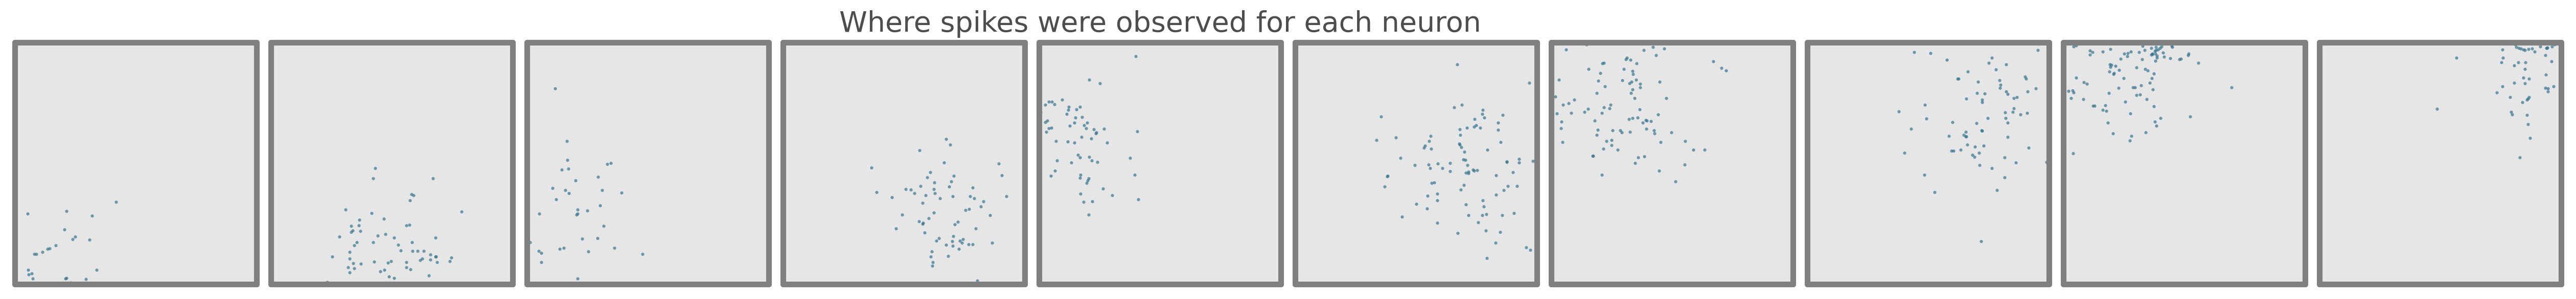

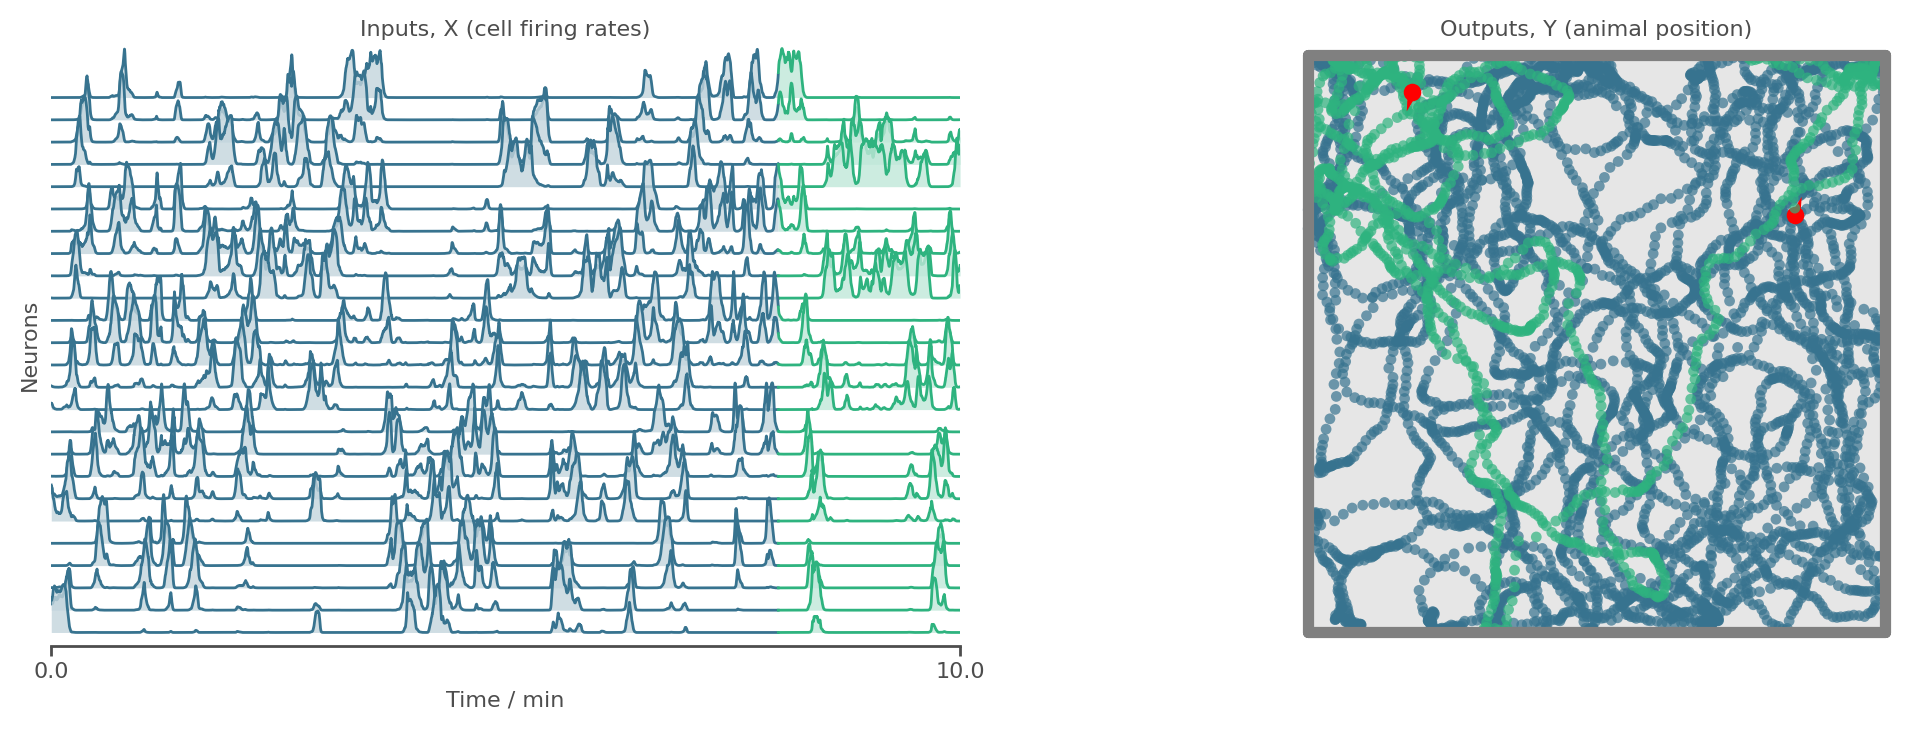

In [13]:
#@title Run this cell to plot the data {display-mode: "form"}
fig, ax = PCs.plot_rate_map(chosen_neurons='10',spikes=True,method='neither') #show the place cells
ax[4].set_title("Where spikes were observed for each neuron",fontdict={'fontsize':20})

# visualise the training a testing data
fig1, ax1 = plt.subplots(1,2,figsize=(10,3))
PCs.plot_rate_timeseries(fig=fig1,ax=ax1[0], t_end=train_frac*T*60, color='C1')
PCs.plot_rate_timeseries(fig=fig1,ax=ax1[0],t_start=train_frac*T*60,color='C2')
Ag.plot_trajectory(fig=fig1, ax=ax1[1], t_end=train_frac*T*60, color='C1', plot_agent=False)
Ag.plot_trajectory(fig=fig1, ax=ax1[1], t_start=train_frac*T*60, color='C2', plot_agent=False)
ax1[0].set_title("Inputs, X (cell firing rates)")
ax1[1].set_title("Outputs, Y (animal position)")

### **0.5 Abstract model class** <a name="model-class"></a>
Before we start we'll make an abstract model class that we'll use to test, train and visualise future models that we'll build.

In order ot initialise a model we must pass in the training and test datasets.
```python
MyModel = Model(X_train=X_train,
                Y_train=Y_train,
                X_test=X_test,
                Y_test=Y_test,)
```

It's most important atributes are:
* `MyModel.n_in`: Size of the inputs (e.g. how many neurons)
* `MyModel.n_out`: Size of outputs (e.g. 2 for 2D position data)
* `MyModel.history`: History data over training.

It's important methods are:
* `MyModel.forward(x)`: takes one or many data points and returns the model predictions (NOT YET DEFINED)
* `MyModel.fit()`: Fits the model paramters using the training data (NOT YET DEFINED)
* `MyModel.plot_testing_performance()`: Visualise the performance of the network

In [15]:
#@title Abstract class (we'll use this a few times for different types of Model) {display-mode: "form"}
# You can ignore most of this boiler plate code, it's just to make sure that all models have the same interface and plotting functions
class Model:
    def __init__(self,
                 X_train=X_train,
                 Y_train=Y_train,
                 X_test=X_test,
                 Y_test=Y_test,
                 use_bias=False, # we won't use a bias now but will do later
                 ):
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.use_bias = use_bias
        self.n_train = self.X_train.shape[1]
        self.n_in = self.X_train.shape[0]
        self.n_out = self.Y_train.shape[0]

        #epoch counter and save history
        self.epoch = 0
        self.history = {'epoch':[],'loss':[], 'test_loss':[], 'error':[], 'test_error':[]}

    def forward(self, X):
        """Each model must have a forward function which takes some array of inputs X and returns the predicted outputs Y_pred"""
        raise NotImplementedError

    def fit(self):
        """Each model must have a fit function which, in one way or another, uses the training data to optimise the parameters (weights) of the model."""
        raise NotImplementedError

    def plot_testing_performance(self, fig=None, ax=None, title=None):
        """Plot the predicted and true trajectory of the agent and the average error"""
        X = self.X_test
        Y = self.Y_test
        Y_pred = self.forward(X)
        fig, ax = Ag.plot_trajectory(fig=fig,ax=ax,t_start=T*train_frac*60, color='C2', show_agent=False)
        ax.scatter(Y_pred[0,:], Y_pred[1,:], color='r', alpha=0.7, s=1, zorder=2)
        lin_error_before = error(Y_pred,Y)
        if title is None: title = self.name
        title += f"\n(av. error = {100*lin_error_before:.2f} cm)"
        ax.set_title(title)
        return fig, ax

    def plot_training_error(self, comparison=None):
        """Plot the training and testing error as a function of epoch. `comparison` can be a model or a list of models: the performance of these models is plotted on top of the training curve."""
        fig, ax = plt.subplots(figsize=(3,2))
        epochs = self.history['epoch']
        train_error = self.history['error']
        test_error = self.history['test_error']
        ax.plot(epochs, train_error, label='train',c='C1',linewidth=1)
        ax.plot(epochs, test_error, label='test',c='C2',linewidth=1)
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Error / cm")
        ax.set_yscale('log')
        if comparison is not None:
            if not isinstance(comparison, list):
                comparison = [comparison]
            for (i,comparison_) in enumerate(comparison):
                Y_comp = comparison_.forward(self.X_test)
                error_comp = error(Y_comp, Y_test)
                ax.axhline(error_comp, c='C'+str(3+i),linestyle="--",label=comparison_.name+" comparison")
        ax.legend()
        return fig, ax

    def add_dummy_row(self,X):
        """X is shape (N, T), add a row of ones to the first column making it (N+1 x T) if and only is self.use_bias is True. Ignore this function for now."""
        if self.use_bias == True:
            return np.vstack((np.ones((1,X.shape[1])), X))
        else:
            return X

def loss(Y_pred, Y_true):
    """Mean squared error"""
    return np.mean((Y_pred-Y_true)**2)

def error(Y_pred, Y_true):
    """How far, in meters, the predictions are away from the true values (on average)"""
    return np.mean(np.linalg.norm(Y_pred-Y_true, axis=0))

---
## **1. Linear regression** <a name="linear-regression"></a>

<center><img src="https://github.com/TomGeorge1234/DeepLearningTutorial/blob/main/figs/sb.png?raw=1" width=300></center>

First, as a benchmark, lets study the most trivial network possible: a linear network with no hidden layers.

A set of weights $W \in \mathbb{R}^{2 \times N_{\textrm{cells}}}$ maps the inputs (firing rates) to the outputs (position).

The hat on $\hat{y}$ represents the fact this is our "estimate" of the output, not necessarily the correct output:

$$\begin{align}\hat{\vec{y}}^{(n)} = W \cdot \vec{x}^{(n)}  \end{align}$$
as a matrix equation this reads
$$\begin{align} \begin{bmatrix} \hat{\mathsf{x}}^{(n)} \\ \hat{\mathsf{y}}^{(n)} \end{bmatrix} = \begin{bmatrix} \textrm{w}_{1,1} & \textrm{w}_{1,2} & \cdot \cdot \cdot & \textrm{w}_{1,N_{\textrm{cells}}} \\ \textrm{w}_{2,1} & \textrm{w}_{2,2} & \cdot \cdot \cdot & \textrm{w}_{2,N_{\textrm{cells}}} \end{bmatrix} \begin{bmatrix} \textrm{firing-rate-of-place-cell-1} \\ \textrm{firing-rate-of-place-cell-2} \\ \cdot \cdot \cdot \\ \textrm{firing-rate-of-place-cell-N} \end{bmatrix} \end{align}$$
in words this reads...
$$
\begin{align}
\mathsf{x}\textrm{-position} &= \textrm{weight}_{1,1} \times \textrm{firing-rate-of-place-cell-1}  \nonumber \\
&+  \textrm{weight}_{1,2} \times \textrm{firing-rate-of-place-cell-2}   \nonumber \\
&+ \cdot \cdot \cdot \nonumber \\
&+ \textrm{weight}_{1,N_{\textrm{cells}}} \times \textrm{firing-rate-of-place-cell-N}  \nonumber
\end{align}
$$
$$
\begin{align}
\mathsf{y}\textrm{-position} &= \textrm{weight}_{2,1} \times \textrm{firing-rate-of-place-cell-1}  \nonumber \\
&+  \textrm{weight}_{2,2} \times \textrm{firing-rate-of-place-cell-2}  \nonumber \\
&+ \cdot \cdot \cdot \nonumber \\
&+ \times \textrm{weight}_{2,N_{\textrm{cells}}} \textrm{firing-rate-of-place-cell-N} \nonumber
\end{align}
$$
and the same for the y-position. It's a very simple model, we'll see how it performs.

<center><img src="https://github.com/TomGeorge1234/DeepLearningTutorial/blob/main/figs/linear_model.png?raw=1" width=300></center>

> **_📝TASK_** If the there are 25 inputs (i.e. 25 "place cells"), and 2 outputs (i.e. x and y-position) _how many parameters_ does this model have.

> **_📝TASK_** Here's a regression problem with four "place cells" in the four corners of an environment. Just by _looking_, can you choose the weights to "best" predict position?
> <center><img src="https://github.com/TomGeorge1234/DeepLearningTutorial/blob/main/figs/linear_regression_by_hand.png?raw=1" width=700></center>
>
> Hint: Write down an expression for $y$ in terms of the neuron activity and the weights when the position is $[0.25,0.25]$ and see what it looks like?
>
> Discuss whether you think this is a "good" model or not. Where would it _not_ work well?
>
> Discuss what would be the "best" weights if you had 100, not just 4 neurons. Would it be easy to do this by hand?


#### **1.0.1 Bias term** <a name="bias-term"></a>
A slightly better linear model would also include a bias $\hat{\vec{y}}^{(n)} = W \cdot \vec{x}^{(n)}  + \vec{b}$. The simple way to do which we use here is to append a fixed "dummy row" to all inputs $\vec{x}^{(n)}_{0} = 1$ then the first weight $W_{:,0} = \vec{b}$ acts as a bias term. **We won't use a bias now but we will use one later with deeper models.**

### **1.1 Building the model** <a name="build-linear-model"></a>
Let's build the model

In vector notation, the forward model equation reads

\begin{equation}
Y = W \cdot X
\end{equation}

> **_📝TASK_** Finish the code line where we calcualate the outputs from the inputs, i.e. write equation (1). Remember! In python we do dot products the the `@` symbol.


In [17]:
#An instance of this class for our current model of interest: Linear regression
class LinearModel(Model):
    """A linear regression model"""
    def __init__(self,
                 **kwargs, #passed to parent class
                 ):
        super().__init__(**kwargs)
        self.name="Linear Model"
        n_in = self.X_train.shape[0] #shape of input
        n_out = self.Y_train.shape[0] # shape of output
        self.W = np.random.normal(loc=0.5,scale=0.1,size=(n_out,n_in+self.use_bias)) #weights (maybe including the bias)

    def forward(self, X):
        W = self.W #the weights
        ####################################
        Y = W @ X # <-------------- YOUR CODE HERE
        ####################################
        return Y

In [ ]:
#@title Double click to see the solution {display-mode: "form"}
#An instance of this class for our current model of interest: Linear regression
class LinearModel(Model):
    """A linear regression model"""
    def __init__(self,
                 **kwargs, #passed to parent class
                 ):
        super().__init__(**kwargs)
        self.name="Linear Model"
        n_in = self.X_train.shape[0] #shape of input
        n_out = self.Y_train.shape[0] # shape of output
        self.W = np.random.normal(loc=0.5,scale=0.1,size=(n_out, n_in+self.use_bias)) #weights (maybe including the bias)

    def forward(self, X):
        W = self.W #the weights
        Y = W @ X
        return Y

> **_📝TASK_** Initialise a model `LinMod = LinearModel()` and use the method `LinMod.plot_testing_performance()` to visualise how well the model does _before_ fitting.

(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'Linear Model\n(av. error = 117.52 cm)'}>)

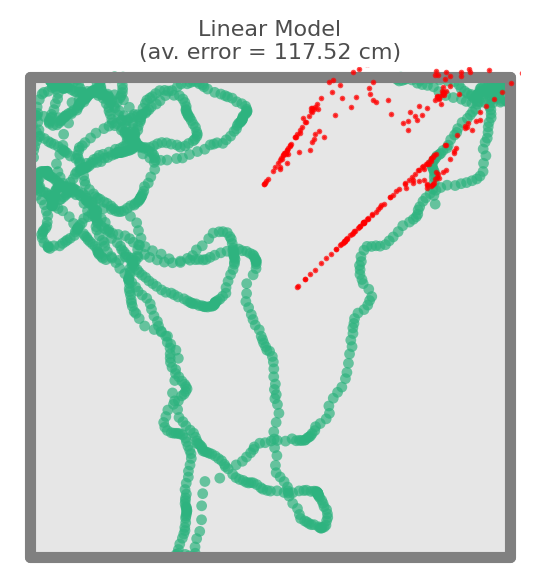

In [18]:
# Your code goes here
LinMod = LinearModel()
LinMod.plot_testing_performance()

### **1.2 Optimising linear models** (_without_ gradient descent) <a name="linear-regression-solution"></a>

We want to find the weights which minimise some measure of "loss" between out estimate $\hat{y}$ and the true value of the agents position $y$. For this we will use the $L_2$ loss:

$$L(D_{\textrm{train}};W) = \sum_{n = 1}^{N_{\textrm{train}}}||\hat{y}^{(n)} - y^{(n)}||^{2}$$

To minimise this we could use gradient descent (which we will do in the next section) but, in fact, this model is simle enough we can solve immediately for the minimum by finding where its derivative with respect to the weights equals to zero. Note this analytic approach won't be possible later on with deeper non-linear models.

$$\frac{\partial L}{\partial W} \bigg \vert_{W=W^*} = 0$$

<center><img src="https://github.com/TomGeorge1234/DeepLearningTutorial/blob/main/figs/loss_minima.png?raw=1" alt="Linear model" width=250 /></center>

The solution to the above equation is (in vector notation):

$$ \begin{equation}W^* = (Y\cdot X^{\mathsf{T}})\cdot(X \cdot X^{\mathsf{T}})^{-1}\end{equation} $$

Let's break this down, you should have seen some of these terms before...:
* $\Sigma_{X} = X \cdot X^{\mathsf{T}}$ is a square matrix of size $N_{\textrm{cells}} \times N_{\textrm{cells}}$. This is the covariance matrix of the inputs.
* $\Sigma_{XY} = Y\cdot X^{\mathsf{T}}$ is a matrix of size $2 \times N_{\textrm{cells}}$. This is the covariance matrix of the inputs and outputs.
* $W^* = \Sigma_{XY} \cdot \Sigma_{X}^{-1}$ is the optimal weights, it has shape $2 \times N_{\textrm{cells}}$.
We'll add a method called `fit` to our linear model which sets the weights according to the above equation

#### **1.2.1 Derivation of the optimal weights in 1 dimension** <a name="optimal-weights"></a>
We can get a feeling for where this formula come from...let's do it in 1D. For example $y^{(n)} \in \mathbb{R}$ and $x^{(n)} \in \mathbb{R}$ might be the price and size of a house. Our goal is to predict the price from the size using a linear model:

<center><img src="https://github.com/TomGeorge1234/DeepLearningTutorial/blob/main/figs/house_price.png?raw=1" alt="House" width=250 /></center>


$$\hat{y}^{(n)} = W x^{(n)} $$

So the "loss" is:

$$L(D_{\textrm{train}};W) = \sum_{n = 1}^{N_{\textrm{train}}}(\hat{y}^{(n)} - y^{(n)})^{2} = \sum_{n = 1}^{N_{\textrm{train}}}(\underbrace{W x^{(n)} - y^{(n)}}_{u^{(n)}})^{2}$$

To calculate minima, and therefore the best weights, we need to find where the derivative of the loss with respect to the weights is zero. For this we'll use the **chain rule**

> **_📝TASK_** Show that (we'll do this together on the board):
>
> $$\frac{\partial L}{\partial W} = 2 \big( W \sum_{n = 1}^{N_{\textrm{train}}} x^{(n)} x^{(n)} - \sum_{n = 1}^{N_{\textrm{train}}} y^{(n)} x^{(n)} \big)$$
>
> Since these are just _numbers_, not matrices, we
>
> $$W = \frac{\sum_{n = 1}^{N_{\textrm{train}}} y^{(n)} x^{(n)}}{\sum_{n = 1}^{N_{\textrm{train}}} x^{(n)} x^{(n)}} := \frac{\Sigma_{XY}}{\Sigma_{X}} = \Sigma_{XY} \Sigma_{X}^{-1}$$

> **_📝TASK_** Here's some data. It could represent _house prices vs. size_, _age vs height_, _exam score vs. IQ_...or whatever. Use what you just learned to fit a 1D linear model, $ y = Wx $

W = 5.1710256993404595


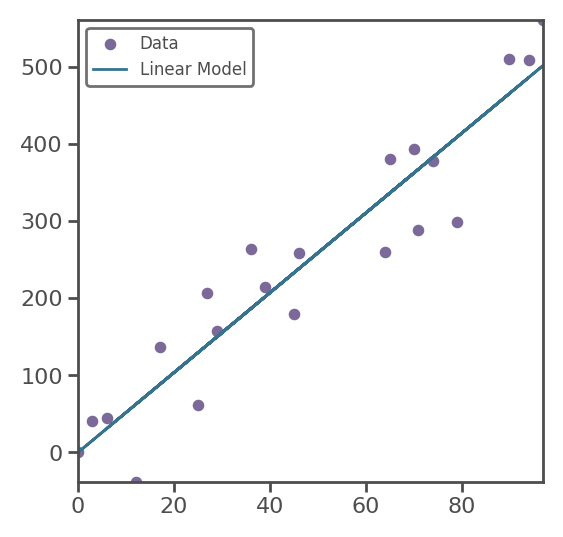

In [20]:
X = np.array([ 45,  12,  39,   6,  29,  90,  64,  94,  79,  17,  71,   3,  0,  25,  70,  27,  36,  97,  74,  65,  46])
Y = np.array([180, -38, 215,  45, 158, 510, 260, 509, 299, 137, 289,  41,  0,  61, 393, 207, 264, 561, 378, 381, 259])

sigma_X = np.sum(X*X) ### <---------------------- YOUR CODE HERE
sigma_XY = np.sum(X*Y) ### <---------------------- YOUR CODE HERE
W = sigma_XY / sigma_X ### <---------------------- YOUR CODE HERE

print(f"W = {W}")

fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(X,Y,label='Data',s=10)
ax.plot(X,W*X,label='Linear Model', c='C1')
ax.legend()

In [ ]:
#@title Double click to see the solution {display-mode: "form"}
X = np.array([ 45,  12,  39,   6,  29,  90,  64,  94,  79,  17,  71,   3,  0,  25,  70,  27,  36,  97,  74,  65,  46])
Y = np.array([180, -38, 215,  45, 158, 510, 260, 509, 299, 137, 289,  41,  0,  61, 393, 207, 264, 561, 378, 381, 259])

sigma_X = np.sum(X*X)
sigma_XY = np.sum(X*Y)
W = sigma_XY / sigma_X

print(f"W = {W}")

fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(X,Y,label='Data',s=10)
ax.plot(X,W*X,label='Linear Model', c='C1')
ax.legend()

#### **1.2.2 Coding the optimal weights in higher dimensions** <a name="high-d-linear-fit"></a>

> **_📝TASK_** Finish the code line where we calcualate the optimal weights from the training data, i.e. write equation (1),
>Hint!! Remember that in python dot products are done with the `@` symbol. You may like to use `np.linalg.inv()` to do the matrix inverse.

In [21]:
def fit(Model):
    """Fit the linear model to the training data"""
    X = Model.X_train #<-- just accounts for the bias
    Y = Model.Y_train
    ####################################
    Model.W = (Y @ X.T) @ np.linalg.inv(X @ X.T) #<--------- YOUR CODE HERE (some combination of X and Y)
    ####################################

LinearModel.fit = fit # assign this method to the linear model class

In [22]:
#@title Double click to see solution {display-mode: "form"}
def fit(Model):
    """Fit the linear model to the training data"""
    X = Model.X_train
    Y = Model.Y_train
    Model.W = (Y @ X.T) @ np.linalg.inv(X @ X.T)   # w = (X^T X)^-1 X^T Y
LinearModel.fit = fit # assign this method to the linear model class

### **1.3 Linear model performance** <a name="linear-model-performance"></a>
Now lets check out the performance of our linear model.

We can do this using the `LinearModel.plot_testing_performance()` function _before_ and _after_ fitting with `LinearModel.fit()`.

(<Figure size 1200x600 with 2 Axes>,
 <Axes: title={'center': 'Linear model after fitting\n(av. error = 8.71 cm)'}>)

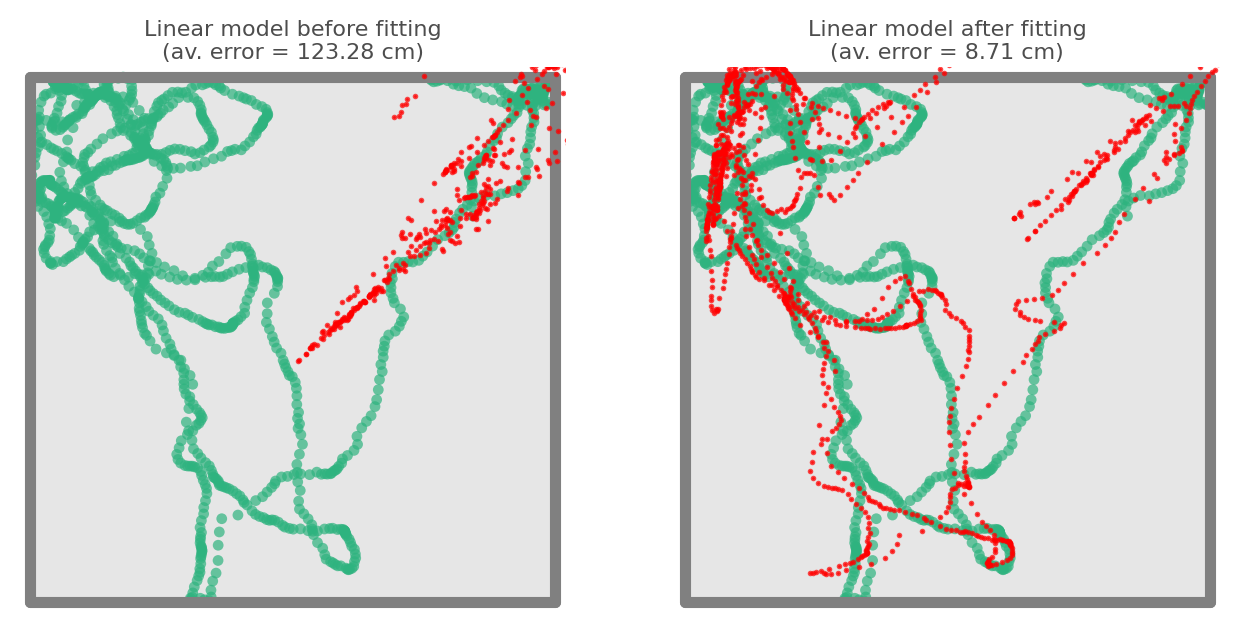

In [23]:
LinMod = LinearModel()

fig, ax = plt.subplots(1,2,figsize=(6,3))
#before fitting (random weights)
LinMod.plot_testing_performance(fig=fig,ax=ax[0],title="Linear model before fitting")

#after fitting (using bias)
LinMod.fit()
LinMod.plot_testing_performance(fig=fig,ax=ax[1],title="Linear model after fitting")

### **1.4 Interpreting the weights**<a name="interpretation"></a>

Can we "interpret" how the model solves this regression problem.

Let's just try and visualise the strength of the weight vs the position of place cells they are connected to.

Weight matrix is:  [[ 0.04319945  0.11040882  0.35165781  0.20750639  0.75336025  0.00390916
   0.00885047  0.111017   -0.057635    0.25787542  0.09624608  0.02630846
   0.35868799  0.16370779  0.6690641  -0.04517766  0.10033903  0.01748927
   0.04224648  0.16012307  0.06318328  0.05280988  0.43429421  0.09197315
   0.86212536]
 [ 0.02417809  0.03336827  0.0201055   0.00389099  0.07121705  0.13029649
  -0.02546611  0.10595498  0.02409261  0.06712617  0.30450739  0.19498093
   0.25879844  0.1176983   0.39266518  0.17368594 -0.04591895  0.10842778
   0.07394979  0.0394338   0.88017507  0.17331292  0.85773861  0.08338754
   0.93800472]]


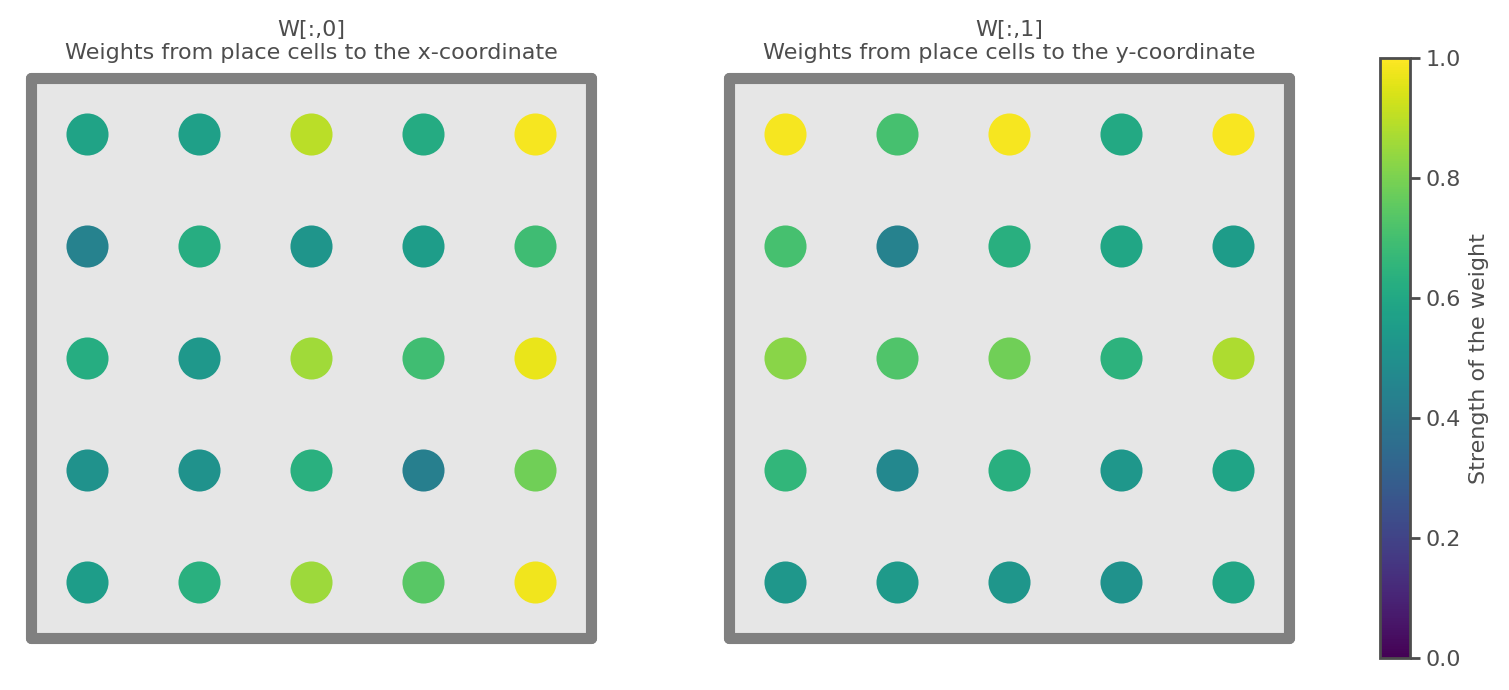

In [24]:
###########################
# you can mostly ignore this code, just run it and see what happens (discuss with your neighbour)
###########################

fig, ax = plt.subplots(1,2,figsize=(8,3))
fig, ax[0] = Env.plot_environment(fig=fig,ax=ax[0])
fig, ax[1] = Env.plot_environment(fig=fig,ax=ax[1])

#scale the weights so they plot nicely
weights = copy.deepcopy(LinMod.W)
print("Weight matrix is: ", weights)
sigmoid = lambda x: 1/(1+np.exp(-x))
weights = sigmoid(weights/0.2)
cmap = matplotlib.colormaps['viridis']

#plot the weights against their plcae cell centres
for i in range(n_cells):
    [x,y] = list(PCs.place_cell_centres[i])
    [W0, W1] = list(weights[:,i])
    ax[0].scatter(x,y,color=cmap(W0),s=200)
    ax[1].scatter(x,y,color=cmap(W1),s=200)
ax[0].set_title("W[:,0]\nWeights from place cells to the x-coordinate")
ax[1].set_title("W[:,1]\nWeights from place cells to the y-coordinate")
fig.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), ax=ax, label="Strength of the weight")

* By connecting **stongly/weakly** to place cells on the **right/left** the network output is high only when the agent is near the right, otherwise low...thus it **encodes x-position**.
* By connecting **stongly/weakly** to place cells at the **top/bottom** the network output is high only when the agent is near the top, otherwise low...thus it **encodes y-position**.

Before we progress, consider how valuable this is! We can intuitively understand _how_ our network is solving the task. Deep Neural Networks (coming up soon) may often perform better than linear regression models but it will be much harder to understand how they work. Everything has a cost!

> **_📝TASK_** Here is the code to make the _four_ place cell example we did by hand earlier.
>```python
>PCs = PlaceCells(Ag, params={
>    'place_cell_centres': np.array([[0.25,0.25],[0.75,0.25],[0.25,0.75],[0.75,0.75]]),
>    'description':'one_hot'
>})
>```
> Scroll to the top section 0.1, replace the line starting `PCs = ...` with the above. Re-run the code and _see_ if the optimised weights match your predictions.

> **_📝TASK_** Scroll back to section 0.1 and return the code to how it was
> ```python
> PCs = PlaceCells(Ag,params={'n':n_cells,'widths':0.15, 'place_cell_centres':place_cell_centres})
> ```
> Regenerate the data...we'll need it for the next section.

---


## **2. Gradient descent**: when models get complicated <a name="gradient-descent"></a>

Maybe we weren't happy with our linear regressor. So we decided to try a more complex model (we'll see one very soon)...
What if the loss function is _too complicated_ to solve analytically?!  One (very successful) way around this problem is called gradient descent.

**<center>Gradient Descent: Instead of directly calculating where the minimum of the loss function is, take little steps down the hill until we settle at the minima </center>**

Here's the trick

**<center>If we know the derivative of the loss function, we can adjust that weight to take a step down the loss landscape and therefore decrease the loss (improve the model). </center>**


<center><img src="https://github.com/TomGeorge1234/DeepLearningTutorial/blob/main/figs/gradient_descent.png?raw=1" width=400 /></center>

Algorithm (1D version)
1. Initialise the weights
2. Update the weights. For each weight:
    * If the gradient of the loss wrt the weight is _positive_, _decrease_ the weight.
    * If the gradient of the loss wrt the weight is _negative_, _increase_ the weight.
3. Repeat step two until convergence

This intution is summarised by the following update rule:

$$ \delta W = -\eta \frac{\partial L}{\partial{W}} $$

**_📝TASK_** Convince yourself that the following update rule is guaranteeed to result in a new loss $L(W+\delta W)$ smaller (or at worst, the same) than the current $L(W)$.


Here's a summary of the last 40 years of machine learning:

**Large scale implementations of gradient descent have been _unreasonably_, and (mostly) _unexplainably_ successful. A majority of problems which people thought were limited to human intelligence have been solved by implementations of this algorithm.**  

We'll discuss later what this tell us about about the brain itself (perhaps less than you'd expect!).

### **2.1 A toy example in one-dimension**<a name="1D-gradient-descent"></a>

Maybe a simple example will help before we move on.

* Imagine that we have a model with only one weight parameter, $w$.
* Now suppose we've calculated the loss function, it has the following form:
$$L(D_{\textrm{train}}; W) = W^2$$
* So we calculate the derivative using some basic calculus:
$$\frac{dL}{dW} = 2W$$
* If our weight starts at $W(0)=-1$ and we have a small learning rate of $\eta=0.1$, lets calculate the weight update.
$$
\begin{align}
\delta W &= -\eta \frac{dL}{dW} \\
&= -\eta \cdot 2W \\
&= - 0.1 \cdot 2 \cdot -1 \\
&= 0.2
\end{align}
$$
* So we update the weight:
$$
\begin{align}
W(1) &= W(0) + \delta W \\
&= -1 +0.2 \\
&=-0.8
\end{align}
$$
* Now lets repeat steps 4 and 5:
$$
\begin{align}
\delta W &= -\eta \cdot 2W \\
&= - 0.1 \cdot 2 \cdot -0.8 \\
&= 0.16
\end{align}
$$
$$
\begin{align}
W(2) &= W(1) + \delta W \\
&= -0.8 + 0.16 \\
&=-0.64
\end{align}$$

**_📝TASK_** Calculate $W(3)$.

In [30]:
W_3 = -0.64 - 0.1*2*(-0.64)
W_3

-0.512

In [26]:
#@title Double click to see solution {display-mode: "form"}

# W(3) = -0.512

#### **2.1.1 Now lets convert this to code** <a name="1D-gradient-descent-code"></a>
**_📝TASKS_**
* Complete the following block of code, does the update rule minimise the loss?  
* Try again but initialisa at $W(0) = 1$
* Repeat this but with the slightly more complex loss function $L(W) = W^4 + W^3 - W^2 - W$. What do you find when $W(0) = -1.5$ and $\eta=0.01$?

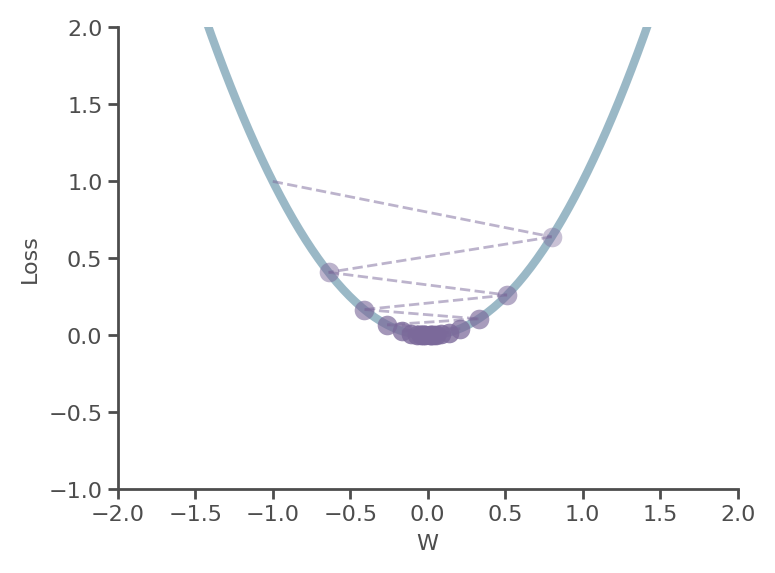

In [34]:
def loss_function(W):
    return W**2

def derivative_of_loss_function(w):
    ######################################
    return 2 * w # YOUR CODE HERE
    ######################################

#format the plot
W_range = np.linspace(-2,2,100)
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(W_range, loss_function(W_range),c='C1',linewidth=3,alpha=0.5)
ax.set_ylim(-1.0,2)
ax.spines['top'].set_visible(False); ax.set_xlabel("W")
ax.spines['right'].set_visible(False); ax.set_ylabel("Loss")

#Initialise the weight and learning rate
W = -1.0
eta = 0.9

#Plot the loss function and the weight
N_steps = 20
for i in range(N_steps):
    ax.scatter(W, loss_function(W), color='C0',alpha=i**0.3/N_steps**0.3,s=50,zorder=11,linewidth=0)
    #######################################
    delta_w = -eta*derivative_of_loss_function(W)#NotImplemented # YOUR CODE HERE
    #######################################
    W_prev = W
    W = W + delta_w
    ax.plot([W_prev, W], [loss_function(W_prev), loss_function(W)], color='C0',linewidth=1,alpha=0.5,linestyle='--')


In [ ]:
#@title Double click to see solution { display-mode: "form" }
def loss_function(W):
    return W**2

def derivative_of_loss_function(W):
    return 2*W

#format the plot
W_range = np.linspace(-2,2,100)
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(W_range, loss_function(W_range),c='C1',linewidth=3,alpha=0.5)
ax.set_ylim(-1.0,2)
ax.spines['top'].set_visible(False); ax.set_xlabel("W")
ax.spines['right'].set_visible(False); ax.set_ylabel("Loss")

#Initialise the weight and learning rate to w = -1, eta=0.1
W = -1.0
eta = 0.1

#Plot the loss function and the weight
N_steps = 20
for i in range(N_steps):
    ax.scatter(W, loss_function(W), color='C0',alpha=i**0.3/N_steps**0.3,s=50,zorder=11,linewidth=0)
    delta_w = -eta*derivative_of_loss_function(W)
    W_prev=W
    W = W + delta_w
    ax.plot([W_prev, W], [loss_function(W_prev), loss_function(W)], color='C0',linewidth=1,alpha=0.5,linestyle='--')


> **_📝TASK_** In light of the second example...what should we be aware of when using gradient descent?
>
> **_📝TASK_** Repeat the above but with a large learning rate of, say, 0.9. What do you observe?  

---

## **3. Deep neural networks** (trained _without_ autograd packages)<a name="DNNs"></a>


<center><img src="https://github.com/TomGeorge1234/DeepLearningTutorial/blob/main/figs/dnn.png?raw=1" width=600 /></center>


Linear regression didn't perform very well. We would like a model which is:
* **More complex** (aka "expressive"), so it can capture the mapping from firing rates to positions more accurately.
* This model should still be **a function of some weights** which we can update with gradient descent.


Here we're going to build a small *neural network* with two hidden layers and train it with backpropagation to solve the same task: predicting position from neural firing rates. Each layer will be non-linear function of the layer before it. It will help to differentiate between the activations of the layers _pre-_ and _post-activation_, which we'll call $n_i$ and $h_i$ respectively:

By stacking multiple non-linear layers we create complex and expressive networks which have proved successful at solving many tasks in ML.


$$
\begin{align}
\textrm{pre-activations} \hspace{8mm} & \hspace{5mm} \textrm{post-activations} \nonumber \\
\vec{n}^{(1)} = W^{(1)} \cdot \vec{x}  \hspace{1cm}&\hspace{1cm} \vec{h}^{(1)} = \sigma (\vec{n}^{(1)}_i) \\
\vec{n}^{(2)} = W^{(2)} \cdot \vec{h}^{(1)}  \hspace{1cm}&\hspace{1cm} \vec{h}^{(2)} = \sigma (\vec{n}^{(2)}) \\
\vec{n}^{(3)} = W^{(3)} \cdot \vec{h}^{(2)} \hspace{1cm}&\hspace{1cm} \hat{\vec{y}} = \sigma (\vec{n}^{(3)})
\end{align}
$$

in a single equation:

$$
\hat{\vec{y}}^{(n)} = \sigma( W^{(3)}  \cdot \sigma( W^{(2)} \cdot \sigma( W^{(1)} \cdot \vec{x}^{(n)} )) )
$$

or, in words,

$$
\begin{align}
\mathsf{x}\textrm{-position} =& \textrm{a-non-linear-function-of-the-weights-and-the-values-of-the-layer-before-it} \nonumber \\
& \textrm{which-is-a-non-linear-function-of-the-weights-and-the-values-of-the-layer-before-it} \nonumber\\
& \cdot \cdot \cdot \nonumber\\
& \textrm{which-is-a-non-linear-function-of-the-firing-rates} \nonumber \\
\nonumber \\
\mathsf{y}\textrm{-position} =& \cdot \cdot \cdot \nonumber
\end{align}
$$

Once again we'll pull the same trick of appending a dummy row to all the inputs (and subsequent hidden layers) to allow for the inclusion of a bias (i.e. the equations above should really read $\vec{h}^{(n)} = \sigma ( W^{(n)} \cdot \vec{h}^{(n-1)}  + \vec{b}^{(n)})$ but we've absorbed the biases into the weights).

> **_📝TASK_** If the there are 25 inputs (i.e. 25 "place cells"), each of the hidden layers has 200 units, and the output is 2D (i.e. x and y-position) calculate _how many parameters_ this network has in total.

### **3.1 Loss function for deep neural networks**<a name="DNN-loss"></a>
The loss, as before, is the $L_2$ loss between the predicted output and the true output. It is a function of the training data and both weight vectors:

$$
\begin{align}
L(D_{\textrm{train}};W^{(1)},W^{(2)},W^{(3)}) &= \frac{1}{N_{\textrm{train}}} \sum_{n = 1}^{N_{\textrm{train}}}||\hat{\vec{y}}^{(n)} - \vec{y}^{(n)}||^{2}
\end{align}
$$

or in words

$$
\textrm{how badly the network is performing} = \textrm{a sum over all datapoints of how far the predicted output is from the true output}
$$


### **3.2 Implementing the DNN in python**<a name="DNN-python"></a>

The following code implements the deep neural network. I have written the functions for `Input-->Layer1` (eq. [1]) and `Layer2-->Output` (eq. [3]).

> **_📝TASK_** It is your task to write the lines that map `Layer0-->Layer1`, `Layer1-->Layer2`, and `Layer2-->Layer3` (eq. [1,2&3]).


In [37]:
class DeepNeuralNetwork(Model):
    """A deep neural network containing two hidden layers"""
    def __init__(self,
                 activation=None, #pass a function here
                 n_hidden=200,
                 eta=0.01,
                 l2=0.01,
                 **kwargs):

        super().__init__(**kwargs, use_bias=True)

        self.name = "Hand-coded DNN"
        self.activation = activation # a function
        self.eta = eta
        self.l2 = l2

        #initialize weights randomly
        self.W1 = np.random.normal(loc=0,scale=2/np.sqrt(self.n_in), size=(n_hidden, self.n_in+self.use_bias))
        self.W2 = np.random.normal(loc=0,scale=2/np.sqrt(n_hidden), size=(n_hidden, n_hidden+self.use_bias))
        self.W3 = np.random.normal(loc=0,scale=2/np.sqrt(n_hidden), size=(self.n_out, n_hidden+self.use_bias))

    def forward(self, X, save=False):

        #input batch
        self.X = X

        #input to hidden layer 1
        self.X_ = self.add_dummy_row(self.X) #add effective dummy row (bias)
        self.N1 = self.W1 @ self.X_ # YOUR CODE HERE
        self.H1 = self.activation(self.N1)# YOUR CODE HERE

        #hidden layer 1 to hidden layer 2
        #################################################
        self.H1_ = self.add_dummy_row(self.H1) #add effective dummy row (bias)
        self.N2 = self.W2 @ self.H1_# YOUR CODE HERE
        self.H2 = self.activation(self.N2)# YOUR CODE HERE
        #################################################

        #hidden layer 2 to output layer
        self.H2_ = self.add_dummy_row(self.H2) #add effective dummy row (bias)
        self.N3 = self.W3 @ self.H2_ # YOUR CODE HERE
        self.Y = self.activation(self.N3) # YOUR CODE HERE

        return self.Y

In [ ]:
#@title Double click to see solution { display-mode: "form" }
class DeepNeuralNetwork(Model):
    """A deep neural network containing two hidden layers"""
    def __init__(self,
                 activation=None, #pass a function here
                 n_hidden=200,
                 eta=0.01,
                 l2=0.01,
                 **kwargs):

        super().__init__(**kwargs)

        self.name = "Hand-coded DNN"
        self.activation = activation # a function
        self.eta = eta
        self.l2 = l2

        #initialize weights randomly
        self.W1 = np.random.normal(loc=0,scale=2/np.sqrt(self.n_in), size=(n_hidden, self.n_in+self.use_bias))
        self.W2 = np.random.normal(loc=0,scale=2/np.sqrt(n_hidden), size=(n_hidden, n_hidden+self.use_bias))
        self.W3 = np.random.normal(loc=0,scale=2/np.sqrt(n_hidden), size=(self.n_out, n_hidden+self.use_bias))

    def forward(self, X, save=False):

        #input batch
        self.X = X

        #input to hidden layer 1
        self.X_ = self.add_dummy_row(self.X) #add effective dummy row (bias)
        self.N1 = self.W1 @ self.X_
        self.H1 = self.activation(self.N1)

        #hidden layer 1 to hidden layer 2
        self.H1_ = self.add_dummy_row(self.H1) #add effective dummy row (bias)
        self.N2 = self.W2 @ self.H1_
        self.H2 = self.activation(self.N2)

        #hidden layer 2 to output layer
        self.H2_ = self.add_dummy_row(self.H2) #add effective dummy row (bias)
        self.N3 = self.W3 @ self.H2_
        self.Y = self.activation(self.N3)

        return self.Y

### **3.3 ReLU non-linearity sits between each layer** <a name="non-linearity"></a>
For the activation function we'll use the rectified linear unit. This is one of the most simple and commonly used non-linearities.

Adding a non-linearity between each layer is crucial to explaining the power of deep learning model. Non-linear functions mean that stacking layers together (the "depp" in "deep neural network") makes the model more complex and expressive.

<center><img src="https://github.com/TomGeorge1234/DeepLearningTutorial/blob/main/figs/activations.png?raw=1" width=800 /></center>


In [39]:
def relu(X,deriv=False):
    "Rectified linear unit. If deriv=True, returns the derivative of the ReLU function (i.e. a step function)."
    if deriv == False:
        return np.maximum(0,X)
    else:
        return 1.0*(X>0)

# =============================================================================
# Optional other activation functions
# =============================================================================

def sigmoid(X,deriv=False):
    "Sigmoid function. If deriv=True, returns the derivative of the sigmoid function."
    if deriv == False:
        return 1.5/(1+np.exp(-X))
    else:
        return 1.5*sigmoid(X)*(1-sigmoid(X))

def tanh(X,deriv=False):
    "Hyperbolic tangent function. If deriv=True, returns the derivative of the tanh function."
    if deriv == False:
        return 1.5*np.tanh(X)
    else:
        return 1.5*(1-np.tanh(X)**2)

### **3.4 Calculating the gradients: "backpropagation"**<a name="DNN-gradients"></a>

Here's the loss function once more:
$$
\begin{align}
L(D_{\textrm{train}};W^{(1)},W^{(2)},W^{(3)}) &= \frac{1}{N_{\textrm{train}}} \sum_{n = 1}^{N_{\textrm{train}}}||\hat{\vec{y}}^{(n)} - \vec{y}^{(n)}||^{2}  \nonumber
\end{align}
$$

Even though the model is now quite a lot more complicated **we can still calculate the gradients using pen-and-paper maths**.

The (very-scary-looking) gradients are as follows:

\begin{align}
\frac{\partial L}{\partial W^{(3)}} = \frac{2}{N_{\textrm{train}}}   &\color{green}{\big(  \sigma^{\prime}(N^{(3)}) \circ (\hat{Y}-Y) \big)} \color{d}{} \cdot H^{(2)^{\mathsf{T}}} \\
\frac{\partial L}{\partial W^{(2)}} = \frac{2}{N_{\textrm{train}}} \color{orange}{\big( \sigma^{\prime}(N^{(2)}) \circ  \big(W^{(3)^{\mathsf{T}}} \cdot }  &\color{green}{\big(  \sigma^{\prime}(N^{(3)}) \circ (\hat{Y}-Y) \big)} \color{orange}{\big) \big)} \color{d}{} \cdot H^{(1)^{\mathsf{T}}}\\
\frac{\partial L}{\partial W^{(1)}} = \frac{2}{N_{\textrm{train}}} \color{pink}{\big(  \sigma^{\prime}(N^{(1)}) \circ \big( W^{(2)^{\mathsf{T}}} \cdot } \color{orange}{\big( \sigma^{\prime}(N^{(2)}) \circ  \big(W^{(3)^{\mathsf{T}}} \cdot }  &\color{green}{\big(  \sigma^{\prime}(N^{(3)}) \circ (\hat{Y}-Y) \big)} \color{orange}{\big) \big)} \color{pink}{\big) \big)}  \color{d}{} \cdot X^{\mathsf{T}}
\end{align}

A few observations...

* **We should recognise all the terms**
    * They're big formulae but all the individual terms make sense. Nothing too scary or new here...
* **The <span style="color:green">green</span> term, $\color{green}{\hat{Y}-Y }$ measures how "wrong" our guess are.**
    * If we are very wrong, we should update our weights a lot.
    * If we are _not_ very wrong, we should update our weights less.
    * This makes sense!  
* **The gradients in layer $(L)$ are _similar to_ the gradients in layer $(L+1)$, multiplied by an extra term.**
    * We always calculate gradients starting from the final layer and "backpropagating" backwards:
* **These are very easy to implement in code.**
    * Where you see $\sigma^{\prime}$ you should replace this with `activation(deriv=True)`
    * Where you see "$\cdot$" you should replace this with `@`
    * Where you see "$\circ$" you should replace this with `*`


#### **3.4.1 OPTIONAL. Derivation of the gradients.**<a name="gradient-derivs"></a>

At the bottom of this notebook you'll find the derivation of this learning. If you're feeling confident in your own time take a look and see if it makes sense. Most of whats there has been taught to you this week!

### **3.5 Stochastic batched gradient descent**<a name="batched-gd"></a>

> Add blockquote

> Add blockquote

> Add blockquote

> Add blockquote









It turns out it can be incredibly computationally expensive to evaluate the gradient on the _whole_ training dataset, $X_{\textrm{train}}$. This is because there may be thousands, even millions of datapoints to average over all at once!

Instead a common approach is to approximate the gradient on a small _batch_ of training data and iterate over many batches. A batch is just a random selection of a small number of the training datapoints. The gradient evaluated on a single batch isn't necessarily correct but it is, _on average_ correct. A batch might consist of a random selection of, say, 1% of the training data points.  

$$L(D_{\textrm{train}}) = \frac{1}{N_{\textrm{train}}}\sum_{i=1}^{N_{\textrm{train}}} L_{i} \approx \frac{1}{N_{\textrm{batch}}}\sum_{j\in J_{\textrm{batch}}}L_{j} $$

### **3.6 Summary**<a name="DNN-summary"></a>

1. We built a complex feed forwards model consisting of multiple stacked non-linear layers: $\hat{\vec{y}}^{(n)} = \sigma( W^{(3)}  \cdot \sigma( W^{(2)} \cdot \sigma( W^{(1)} \cdot \vec{x}^{(n)} )) )$
2. The loss depends deterministically on the weights between each layer: $L(D_{\textrm{train}};W^{(1)},W^{(2)},W^{(3)})$
3. We analytically calculated the _gradient_ of this loss with respect to each of the weights. The equations are written above.
4. We can adjust each weight vector a small amount along the (negative) direction of this gradient. $\delta W = -\eta \frac{\partial L}{\partial W}$. Doing so will decrease our loss and improve our model

Don't confuse gradient descent and backpropagation:
* **Gradient descent**: Applicable to many types of model (not just neural networks), the act of optimising parameters by taking small steps in weight space along the direction of the gradient in the loss function. Been around since the 1800s.
* **Backpropagation**:  Applicable to deep neural network models, the act of efficiently computing the gradient one layer at a time starting from the final layer and working back up through the network. Invented in the 1970s.

### **3.7 Implementing stocastic gradient descent in code** <a name="DNN-gd-pythoncode"></a>

Here we will write a `fit` function. This iterates over the training data in batchs. For each batch it:
1. Runs the `forward` function to calculate the predicted outputs.
2. Uses these predicted values and the above equations to backpropagate through the network and calculate the gradients
3. Update the weights
4. _Optional_: Run the model on the test set and store the current error.

> **_📝TASK_** Finish the code below to implement the `fit` function.

In [46]:
def fit_deep_network(Model,epochs=10,batch_frac=0.01):
    """Fit the deep neural network to the training data using batched stochastic gradient descent"""
    for _ in (pbar := tqdm(range(int(epochs / batch_frac)))):

        ##########################################################################
        # 1. GET A RANDOM BATCH OF TRAINING DATA

        N_batch = int(batch_frac*Model.n_train)
        batch_ids = np.random.choice(Model.n_train,size=N_batch,replace=False)

        X_batch = Model.X_train[:,batch_ids]
        Y_batch = Model.forward(X_batch) #this also saves all the intermediate layer values too e.g. Model.X_, Model.H1_, Model.H2_, Model.N1_, Model.N2_, Model.N3_
        Y_true = Model.Y_train[:,batch_ids]
        b = int(Model.use_bias) #int for whether we're using a bias term or not

        ##########################################################################
        # 2. COMPUTE GRADIENTS

        C3 = Model.activation(Model.N3,deriv=True) * (Y_batch-Y_true) # the term we'll reuse
        dLdW3 = (2/N_batch) * (C3 @ Model.H2_.T)

        C2 = Model.activation(Model.N2,deriv=True) * (Model.W3.T[b:,:] @ C3) # YOUR CODE HERE
        dLdW2 = (2/N_batch) * (C3 @ Model.H2_.T) # YOUR CODE HERE

        C1 = Model.activation(Model.N1,deriv=True) * (Model.W2.T[b:,:] @ C2)
        dLdW1 = (2/N_batch) * (C1 @ Model.X_.T)

        ##########################################################################
        # 3. USE GRADIENTS TO UPDATE WEIGHTS

        Model.W3 -= Model.eta * dLdW3        +  Model.eta * Model.l2 * Model.W3 # these last terms are L2 regularisation (you can ignore them for now)
        Model.W2 -= Model.eta * dldW2  + Model.eta * Model.l2 * Model.w2 # YOUR CODE HERE
        Model.W1 -= Model.eta * dLdW1        +  Model.eta * Model.l2 * Model.W1

        ##########################################################################
        # 4. STORE SOME HISTORY DATA

        #compute distance error and save history
        Model.epoch += batch_frac
        Model.history['epoch'].append(Model.epoch)
        Y_pred = Model.forward(Model.X_test)
        E_test = error(Y_pred, Model.Y_test)
        Model.history['error'].append(error(Y_batch,Y_true))
        Model.history['test_error'].append(E_test)
        pbar.set_description(f"Test error (cm): {100*E_test:.3f}")

DeepNeuralNetwork.fit = fit_deep_network

In [47]:
#@title Double click to see solution { display-mode: "form" }
def fit_deep_network(Model,epochs=10,batch_frac=0.01):
    """Fit the deep neural network to the training data using batched stochastic gradient descent"""
    for _ in (pbar := tqdm(range(int(epochs / batch_frac)))):

        ##########################################################################
        # 1. GET A RANDOM BATCH OF TRAINING DATA

        N_batch = int(batch_frac*Model.n_train)
        batch_ids = np.random.choice(Model.n_train,size=N_batch,replace=False)

        X_batch = Model.X_train[:,batch_ids]
        Y_batch = Model.forward(X_batch) #this also saves all the intermediate layer values too e.g. Model.X_, Model.H1_, Model.H2_, Model.N1_, Model.N2_, Model.N3_
        Y_true = Model.Y_train[:,batch_ids]
        b = int(Model.use_bias) #int for whether we're using a bias term or not

        ##########################################################################
        # 2. COMPUTE GRADIENTS

        C3 = Model.activation(Model.N3,deriv=True) * (Y_batch-Y_true) # the term we'll reuse
        dLdW3 = (2/N_batch) * (C3 @ Model.H2_.T)

        C2 = Model.activation(Model.N2,deriv=True) * (Model.W3.T[b:,:] @ C3)
        dLdW2 = (2/N_batch) * (C2 @ Model.H1_.T)

        C1 = Model.activation(Model.N1,deriv=True) * (Model.W2.T[b:,:] @ C2)
        dLdW1 = (2/N_batch) * (C1 @ Model.X_.T)

        ##########################################################################
        # 3. USE GRADIENTS TO UPDATE WEIGHTS

        Model.W3 -= Model.eta * dLdW3        +  Model.eta * Model.l2 * Model.W3 # these last terms are L2 regularisation (you can ignore them for now)
        Model.W2 -= Model.eta * dLdW2        +  Model.eta * Model.l2 * Model.W2
        Model.W1 -= Model.eta * dLdW1        +  Model.eta * Model.l2 * Model.W1

        ##########################################################################
        # 4. STORE SOME HISTORY DATA

        #compute distance error and save history
        Model.epoch += batch_frac
        Model.history['epoch'].append(Model.epoch)
        Y_pred = Model.forward(Model.X_test)
        E_test = error(Y_pred, Model.Y_test)
        Model.history['error'].append(error(Y_batch,Y_true))
        Model.history['test_error'].append(E_test)
        pbar.set_description(f"Test error (cm): {100*E_test:.3f}")

DeepNeuralNetwork.fit = fit_deep_network

### **3.8 Construct and train the DNN**<a name="DNN-training"></a>

**Note**: convergence of this network is not guaranteed (as you may well experience!). It is very likely that the optimisation procedure may get stuck in a local minima. This bug is a very real problem in machine learning and lots of work has been done to ameliorate this issue.

If this happens: try cancelling, reinitialising the network, and starting again.

In [48]:
DNN = DeepNeuralNetwork(
    activation=relu,
    )

(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'Hand-coded DNN\n(av. error = 78.32 cm)'}>)

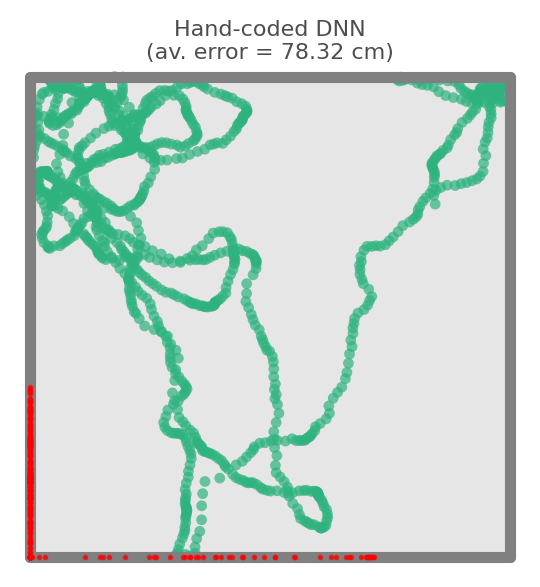

In [49]:
#DNN performance before training
DNN.plot_testing_performance()

In [44]:
DNN.fit(epochs=50)

  0%|          | 0/5000 [00:00<?, ?it/s]

> **_📝TASK_** Discuss...what are the key differences between optimising a linear model and optimising a deep neural network model. When would you prefer one vs. when would you prefer another?

Now lets plot the training and testing error over time, and visualise the performance

(<Figure size 1200x600 with 2 Axes>,
 <Axes: title={'center': 'Hand-coded DNN\n(av. error = 78.32 cm)'}>)

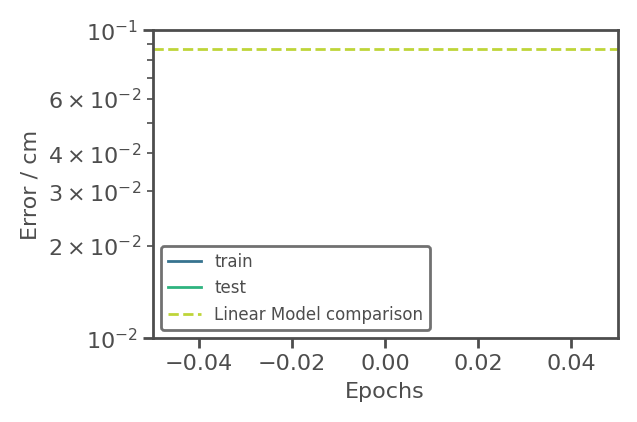

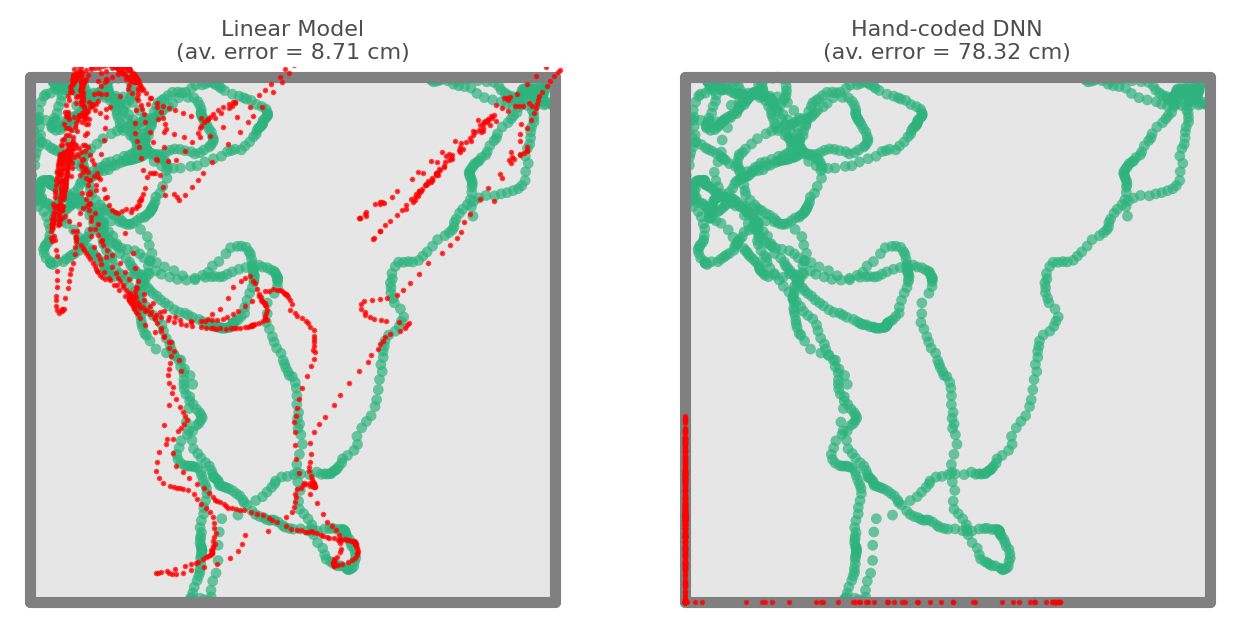

In [50]:
fig, ax = DNN.plot_training_error(comparison=LinMod)

fig, ax = plt.subplots(1,2,figsize=(6,3))
LinMod.plot_testing_performance(fig=fig,ax=ax[0])
DNN.plot_testing_performance(fig=fig,ax=ax[1])

### **3.9 (OPTIONAL) Backpropagation allows us to go deeper and deeper**: A general recursive formula <a name="recursive-backprop"></a>

The elegance of backprop is that we can keep going deep and deeper, extending the above process indefinitely. By stacking more and more layers together we make our model more and more complex (and therefore more powerful!). For each new layer calculating the gradient doesn't get much harder, we just need to calculate two extra terms each time.

Imagine we have a network with $N$ hidden layers (where $\vec{h}^{(0)} := \vec{x}$ is the input and $\vec{h}^{(N+1)} :=\hat{\vec{y}}$ is the output.) The update step for the $n^{\textrm{th}}$ set of weights is:
$$
\delta W^{(n)} = -  \eta \frac{2}{N_{\textrm{batch}}} C^{(n)} \cdot(\hat{Y}-Y)\ \cdot H^{(n-1)^{\mathsf{T}}}
$$
where $C^{(n)}$ is defined recursively fron the layer before (i.e. to the right of) it:
$$
C^{(n)} = \sigma^{\prime}(N^{(n)}) \circ \big(W^{(n+1)^{\mathsf{T}}} \cdot C^{(n+1)} \big)
$$
and the top layer (where the recursion starts) is:
$$C^{(N+1)} = \sigma^{\prime}(N^{(N+1)})$$

There is some nice intuition in these formulae: $(\hat{Y}-Y)$ is the vector of errors and $C^{(n)}$ is the martix which rotates this error into the space along which the $n^{\textrm{th}}$ set of weights influences the output.
Now you can possible see why we call this "_backpropagation_". Starting from the final layer we "propagate" backwards calculating the gradient of each subsequent layer as we go. At each layer we map the error through the _transpose_ of the weight matrix to find the gradient of the layer below it. Contrast this to when we _evaluate_ a neural network in a forward sweep where we multiply by the weight matrix (not it's transpose).

<center><img src="https://github.com/TomGeorge1234/DeepLearningTutorial/blob/main/figs/backprop.png?raw=1" width=800 /></center>


NOTE: Although there is consensus that forward sweeps are plausible in biological networks of neurons there is _no consensus_ that backward sweeps (i.e. backpropagation) are plausible since this would require neural networks to...
* ...store two sets of weights: $W$ and $W^{\mathsf{T}}$
* ...and maintain activity during the forward sweep in order to establish the gradient later , once the backwards sweep has reached.

It is likely neural networks use some coarse approximation to backpropagation or different learning rules altogether.



---

## **4 Deeper neural networks trained with an autograd package, `pytorch`**<a name="pytorch"></a>

### **4.1 Autograd packages calculate gradients automatically and efficiently**<a name="autograd"></a>

Autograd packages such as `pytorch` automate the process we wrote out by hand above. `pytorch` allows you to build arbitrarily complex networks.

It achieves this my maintaining a "memory trace" of all the calculations performed and then when you want to perform gradient descent on the weights it intelligently works back through the memory trace to calculate the gradient with respect to all parameters. It does this efficiently and is optimized for GPU (we won't use this here) so can be used to train _big_ networks on _big_ data sets incredibly fast.

Now we will import `pytorch` and build a deeper neural network to solve the task. At it's core, know that its really just doing the same thing we hard coded up above (but with much less code to write and less maths to do!)...

### **4.2 A friendly warning**<a name="warning"></a>
Whilst it's convenient to automate the process of building neural networks in this way, it can be damaging to our understanding (and to science) if we just blindly use deep neural networks without thinking about what's going on under the hood.


The point of this tutorial is to show you that:
* What's going on under the hood is not magic. It can be understood with basic maths and intuition.
* Oftentimes, if we value _understanding_ over _performance_, other models which are not DNNs/RNNs/CNNs/ChatGPT etc. may be preferable!
    * Remember how we could interpret the meaning of the weights in the linear model...we can't do that any more.


### **4.3 Using `pytorch` to build an even deeper neural network**<a name="pytorch-implementation"></a>
We'll make a network with 5 hidden layers, each containing 100 nodes.

In [ ]:
!pip install torch # pytorch (in case you haven't installed it yet)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class DeepNeuralNetworkTorch(Model,nn.Module):
    def __init__(self,
                 hidden_size=200
                 ):
        Model.__init__(self)
        nn.Module.__init__(self)
        self.layer1 = nn.Linear(self.n_in, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(hidden_size, hidden_size)
        self.layer5 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, self.n_out)
        self.relu = nn.ReLU()
        self.name = "pytorch DNN"
        self.criterion = nn.MSELoss()
        self.optimizer = optim.SGD(self.parameters(), lr=0.1)
        # self.optimizer = optim.Adam(self.parameters())

    def forward(self, X, return_torch=False):
        """Forward pass, X can be numpy array or torch tensor. By default returns a (detached) numpy array but can return a torch tensor if return_torch=True. Do this if you intend to take gradients."""
        X = X.T #pytorch uses a different convention for the shape of the data
        if isinstance(X, np.ndarray):
            X = torch.Tensor(X.astype(np.float32)) #pytorch uses its own kind of linear algebra objects (very similar to numpy)
        X = self.relu(self.layer1(X))
        X = self.relu(self.layer2(X))
        X = self.relu(self.layer3(X))
        X = self.relu(self.layer4(X))
        X = self.relu(self.layer5(X))
        X = self.output_layer(X)
        if return_torch == False:
            X = X.detach().numpy()
        X = X.T #return to the original shape
        return X

    def fit(self, epochs=100, batch_frac=0.1,verbose=True):
        if verbose == True: pbar = tqdm(range(int(epochs / batch_frac)))
        else: pbar = range(int(epochs / batch_frac))
        for _ in pbar:
            #get batch of data
            N_batch = int(batch_frac*self.n_train)
            batch_ids = np.random.choice(self.n_train,size=N_batch,replace=False)
            X_batch = self.X_train[:,batch_ids]
            Y_batch = self.forward(X_batch,return_torch=True)
            Y_true = torch.from_numpy(self.Y_train[:,batch_ids].astype(np.float32))

            #optimize the weights
            self.optimizer.zero_grad()
            loss = self.criterion(Y_batch, Y_true)
            loss.backward() #<--- this is where the magic happens! Gradients are computed here
            self.optimizer.step() #<--- this is also where the magic happens! Weights are updated here

            #compute distance error and save history
            self.epoch += batch_frac
            self.history['epoch'].append(self.epoch)
            Y_pred = self.forward(self.X_test)
            E_test = error(Y_pred, self.Y_test)
            self.history['error'].append(error(Y_batch.detach().numpy(),Y_true.detach().numpy()))
            self.history['test_error'].append(E_test)
            if verbose == True: pbar.set_description(f"Test error (cm): {100*E_test:.3f}")

In [ ]:
TDNN = DeepNeuralNetworkTorch()

In [ ]:
TDNN.fit(epochs=100)

TDNN.plot_training_error(comparison=[LinMod,DNN])

fig, ax = plt.subplots(1,3,figsize=(9,3))
#before fitting (random weights)
LinMod.plot_testing_performance(fig=fig,ax=ax[0])
DNN.plot_testing_performance(fig=fig,ax=ax[1])
TDNN.plot_testing_performance(fig=fig,ax=ax[2])


Not only is it faster (facebook software engineers are better at coding than I am, it would appear), its _really_ accurate! This is down to the improved optimizer and the larger, deeper model.

### **4.4 Optimisers** <a name="optimisers"></a>

We discussed -- then coded up -- _gradient descent_. Its the idea at the core of almost all deep machine learning algorithms. But can we improve this?

One idea, deriving from physics, is that our weights have "momentum". If they're moving in one direction they tend to carry on moving in one direction. This allows them to overcome noise or local minima on the loss landscape. It's like rolling a ball down a valley, it will keep rolling even if there are small bumps in the way.

<center><img src="https://github.com/TomGeorge1234/DeepLearningTutorial/blob/main/figs/gd_withmomentum.gif?raw=1" width=600 /></center>

Another idea is to use _adaptive learning rates_ which allows different weights to learn more or less quickly depending on the recent history of their dynamics. The Adam-optimizer (pre-coded in `pytorch`) implements these ideas. It turns out it works _much better_ than vanilla gradient descent.

> **_📝TASK_** In the code above, replace the `self.optimizer = optim.SGD(self.parameters(), lr=0.1)` with `self.optimizer = optim.Adam(self.parameters())`


### **4.5 Visualise the learning over time** <a name="visualising-learning"></a>

The following code produces an animation showing how the network learns over time

In [ ]:
import matplotlib.animation

epochs = 50
plot_every = 0.4

TDNN = DeepNeuralNetworkTorch()
TDNN.name=""
fig, ax = TDNN.plot_testing_performance()

def animate(i,fig,ax):
    TDNN.fit(epochs=plot_every,verbose=False) #do one more epoch of fitting
    ax.clear()
    ax.text(0.0,-0.06,f"Epoch: {round(TDNN.epoch,2)}",size=7)
    fig, ax = TDNN.plot_testing_performance(fig=fig,ax=ax)
    plt.close()
    return

anim = matplotlib.animation.FuncAnimation(
    fig,
    animate,
    interval=50, #ms between frames
    frames=int(epochs/plot_every),
    blit=False,
    fargs=(fig, ax),)

# anim.save('./figs/DNN.gif', writer='pillow', fps=30)

from IPython.display import HTML
HTML(anim.to_html5_video())

> **_📝TASK_** Rerun the note book but instead of `PlaceCells()` try `GridCells()`. How do the three models (linear regression, hand-coded-shallow DNN, pytorch-DNN) compare?

---

## **Congrats!**
Well done. You made it to the end of the tutorial!

### **Re-use**
Feel free you to adapt and use this tutorial for your own teaching needs!

### **About the author: Tom George**
* Feel free to get in touch at tom.george.20@ucl.ac.uk
* Links: [Twitter](https://twitter.com/TomNotGeorge), [Github](https://github.com/TomGeorge1234), [Google Scholar](https://scholar.google.com/citations?user=AG49j3MAAAAJ&hl=en)

---

## **Derivations**

### **Derivation of linear regression solution**

Linear regression loss is:
$$
\begin{align}
L(D_{\textrm{train}};W) = \sum_{n = 1}^{N_{\textrm{train}}}||\hat{y}^{(n)} - y^{(n)}||^{2} = \sum_{n = 1}^{N_{\textrm{train}}}(\hat{y}^{(n)} - y^{(n)})^{\mathsf{T}}  (\hat{y}^{(n)} - y^{(n)}) \hspace{1cm} \textrm{where} \hspace{1cm} \hat{y}^{(n)} = W\cdot x^{(n)}  
\end{align}
$$

Note we're handling vectors, not scalars, here. $y^{(n)}$ is a column vector with shape (2,) and $x^{(n)}$ is a column vector with shape $(N_{\textrm{cells}},)$. Not to make this a lesson in linear algebra but it will pay to be familiar with vectors and covector. If $a = [a_1,a_2,a_3]^{\mathsf{T}}$ is a vector (often called a column vector since it's written like a column on a page) then $a^{\mathsf{T}} = [a_1,a_2,a_3]$ is the "covector" of a (a row-vector). Lets assume each individual data point $x^{(n)}$ and $y_i$ are _column_-vectors, therefore terms such as $y^{\mathsf{T}} y$ and $x^{\mathsf{T}} x$ are scalars but terms like $yy^{\mathsf{T}}$ and $x x^{\mathsf{T}}$ are square matrices of size ($2 \times 2$) and ($N_\textrm{cells} \times N_\textrm{cells}$) respectively.

We will make use of the chain rule:  

$$\frac{\partial a}{\partial b} = \frac{\partial a}{\partial c}  \frac{\partial c}{\partial b}$$

Lets take derivative with respect the weight matrix, $w$,  and solve for when the derivative is zero.

\begin{align}
\frac{\partial L}{\partial{W}_{jk}} &= \sum_{n = 1}^{N_{\textrm{train}}} \sum_{i} \frac{\partial L^{(n)}}{\partial \hat{y}^{(n)}_i} \frac{\partial \hat{y}^{(n)}_{i}}{\partial W_{jk}}  \\
&= \sum_{n = 1}^{N_{\textrm{train}}} \sum_{i} \frac{\partial L^{(n)}}{\partial \hat{y}^{(n)}_i} \frac{\partial \sum_{l}W_{il}x^{(n)}_{l}}{\partial W_{jk}}  \\
&= \sum_{n = 1}^{N_{\textrm{train}}} \sum_{i} \frac{\partial L^{(n)}}{\partial \hat{y}^{(n)}_i} \sum_{l} x^{(n)}_{l}\delta_{ij}\delta_{lk}  \\
&= \sum_{n = 1}^{N_{\textrm{train}}} \sum_{i} \frac{\partial L^{(n)}}{\partial \hat{y}^{(n)}_i} x^{(n)}_{k}\delta_{ij}  \\
\end{align}

where, from the top, we can see that $\frac{\partial L^{(n)}}{\partial \hat{y}^{(n)}_i} = 2(\hat{y}^{(n)}_i - y^{(n)}_i) = 2([W\cdot x^{(n)}]_{i} - y^{(n)}_i)$ so, plugging this in...

\begin{align}
\frac{\partial L}{\partial{W}_{jk}} &=  \sum_{n = 1}^{N_{\textrm{train}}} \sum_{i} 2*([W\cdot x^{(n)}]_{i} - y^{(n)}_i) x^{(n)}_{k}\delta_{ij} \\
&=  \sum_{n = 1}^{N_{\textrm{train}}}  2 ([W\cdot x^{(n)}]_{j} - y^{(n)}_j) x^{(n)}_{k} \\
\end{align}

or as a vector equation

\begin{align}
\frac{\partial L}{\partial{W}} &= \sum_{n = 1}^{N_{\textrm{train}}}  2 (W\cdot x^{(n)} - y^{(n)}) x^{(n)^{\mathsf{T}}} \\
\end{align}

A useful trick is that the sum over $n$ can be done by replace $x^{(n)},  y^{(n)} \rightarrow X, Y$ since, now, the second dimension of the first term and the first dimension of the second term index over the datapoints so taking the dot product between them will _sum_ over these datapoints.

\begin{align}
\frac{\partial L}{\partial{W}} &=  2 (W \cdot X - Y) X^{\mathsf{T}} \\
\end{align}

Setting equal to zero and rearranging gives the desired solution

\begin{align}
0 &=  2 (W^{*} \cdot X - Y) X^{\mathsf{T}}  \\
Y\cdot X^{\mathsf{T}} &= W^{*} \cdot [X\cdot X^{\mathsf{T}}] \\
W^{*} &= Y\cdot X^{\mathsf{T}} \cdot [X\cdot X^{\mathsf{T}}]^{-1}
\end{align}

#### **3.4.1 OPTIONAL. Derivation of the gradients.**<a name="real-gradient-derivs"></a>

You don't need to understand this maths...
So how do we calculate the gradient? And how do we do this "efficiently"? Since we have all the equations of the model we can just use some simple calculus (the chain rule) to calculate out the gradient by hand. Don't worry if you're not familiar with some of the notation coming up.., we'll step through it bit by bit.

For the sake of the proof we'll assume everything is one dimensional and there's only one datapoint (then just write the extension to multiple dimensions as it's follows the same form) but the full derivation is given at the end.

* Let's start with the weight in the final layer, $W^{(3)}$:

$$
\begin{align}
\frac{\partial L}{\partial W^{(3)}} &= \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial n^{(3)}} \cdot \frac{\partial n^{(3)}}{\partial W^{(3)}}
\end{align}
$$

All three terms here are relatively easy to work out:

$$
\begin{align}
L = ||\hat{y} - y||^{2} \hspace{1cm}  \hspace{1.6cm}  \hat{y} &= \sigma(n^{(3)}) \hspace{1.1cm}  \hspace{1cm} n^{(3)} =  W^{(3)} h^{(2)}  \\
\frac{\partial L}{\partial \hat{y}} = 2(\hat{y} - y) \hspace{1cm}  \hspace{1cm} \frac{\partial \hat{y}}{\partial n^{(3)}} &= \sigma^{\prime}(n^{(3)}) \hspace{1cm}  \hspace{1cm} \frac{\partial n^{(3)}}{\partial W^{(3)}} = h^{(2)}
\end{align}
$$

Putting this together and rearranging gives:

$$\frac{\partial L}{\partial W^{(3)}} = 2 \sigma^{\prime}(n^{(3)}) \cdot (\hat{y} - y) \cdot h^{(2)} $$

* Now lets try calculate the gradient of the weights on the intermediate layer, $W^{(2)}$:

$$
\begin{align}
\frac{\partial L}{\partial W^{(2)}} &= \frac{\partial L}{\partial W^{(2)}} \\
&=  \color{green}{\underbrace{\frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial n^{(3)}}}_{\textrm{already calculated}}} \cdot \color{d}{} \underbrace{\frac{\partial n^{(3)}}{\partial h^{(2)}}  \cdot \frac{\partial h^{(2)}}{\partial n^{(2)}} \cdot \frac{\partial n^{(2)}}{\partial W^{(2)}}}_{\textrm{need to calculate}} \\
&=  \color{green}{ 2\cdot \sigma^{\prime}(n^{(3)}) \cdot (\hat{y} - y)} \cdot \color{orange}{W^{(3)} \cdot \sigma^{\prime}(n^{(2)})} \cdot \color{d} h^{(1)} \\
&=   2 \cdot \color{orange}{\sigma^{\prime}(n^{(2)}) \cdot W^{(3)} } \cdot \color{green}{\sigma^{\prime}(n^{(3)}) \cdot (\hat{y} - y) } \color{d} \cdot h^{(1)} \\
\end{align}
$$

Notice the term coloured in green appeared in the first calculation for $\frac{\partial L}{\partial W^{(2)}}$. We can reuse this so we don't have to calculate it again. This efficiency saving may seem petty now but will be important for very deep networks later on.

* Finally, lets calculate the derivative with respect to the weigths in the first layer, $W^{(1)}$. This time I'll leave it as an **optional excersize** for you to derive it but hopefully you can see some of the patterns emerging. We can pretty much just "look" at the above equations and guess what the next in the pattern will be:

$$ \frac{\partial L}{\partial W^{(1)}} = 2 \cdot \color{pink}{\sigma^{\prime}(n^{(1)}) \cdot W^{(2)}} \cdot \color{orange}{\sigma^{\prime}(n^{(2)}) \cdot W^{(3)} } \cdot \color{green}{ \sigma^{\prime}(n^{(3)}) \cdot (\hat{y} - y)} \color{d} x  $$

#### **3.4.2 VERY OPTIONAL Vectorising our learning rule updates**
**TReND Students you haven't been taugh most of this notation so don't worry if it doesn't make sense yet!**

The above derivation just showed the case for a (trivial) 1D deep neural network (all inputs, hidden layers and outputs 1D) and only found the component of the weight update for one of the datapoints. Here we extend this to the full case. The results end up looking basically the same...just with vectors and matrices instead of scalars and some additional notational bagge to handle these. They end up looking like this:

\begin{align}
\frac{\partial L}{\partial W^{(3)}} &= \frac{2}{N_{\textrm{train}}}   \color{green}{\big(  \sigma^{\prime}(N^{(3)}) \circ (\hat{Y}-Y) \big)} \color{d}{} \cdot H^{(2)^{\mathsf{T}}} \\
\frac{\partial L}{\partial W^{(2)}} &= \frac{2}{N_{\textrm{train}}} \color{orange}{\big( \sigma^{\prime}(N^{(2)}) \circ  \big(W^{(3)^{\mathsf{T}}} \cdot }  \color{green}{\big(  \sigma^{\prime}(N^{(3)}) \circ (\hat{Y}-Y) \big)} \color{orange}{\big) \big)} \color{d}{} \cdot H^{(1)^{\mathsf{T}}}\\
\frac{\partial L}{\partial W^{(1)}} &= \frac{2}{N_{\textrm{train}}} \color{pink}{\big(  \sigma^{\prime}(N^{(1)}) \circ \big( W^{(2)^{\mathsf{T}}} \cdot } \color{orange}{\big( \sigma^{\prime}(N^{(2)}) \circ  \big(W^{(3)^{\mathsf{T}}} \cdot }  \color{green}{\big(  \sigma^{\prime}(N^{(3)}) \circ (\hat{Y}-Y) \big)} \color{orange}{\big) \big)} \color{pink}{\big) \big)}  \color{d}{} \cdot X^{\mathsf{T}}
\end{align}

where $\circ$ is just the element-wise Hadamard product and capitalised terms represent terms vectorised (made into matrices) over the dataset index: $[N^{(2)}]_{n,:} = n^{(2)}_{(n)}$, etc. and $X^{\mathsf{T}}_{ij} = X_{ji}$ is the matrix transpose operator. Notice, again, the saving over the term in the green and orange terms we already calculated on the first two steps which we can reuse on the second and third. Although these formulae may look scary we can build them up slowly one by one and you can se the pattern with each successive layer emerging. In the above we have been lazy and dropped notation for clarity the $X_{\textrm{train}}, H^{(1)}_{\textrm{train}} \cdot \cdot \cdot \rightarrow X, H^{(1)} \cdot \cdot \cdot$,

To derive the vectorised notation we need to be slight more savvy when taking derivatives in order to account for the fact that inputs, outputs and hidden layers are all multidimensional vectors, not scalars. I will show the vectorised form is true for the first derivative $\frac{\partial L}{\partial W^{(3)}}$ and leave the next two as an excersize.

Here's the component of the loss for a single datapoint (we'll consider the sum over all datapoints at the end). To calculate

$$
\begin{align}
\frac{\partial L}{\partial W^{(3)}} &=  \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial n^{(3)}} \cdot  \frac{\partial n^{(3)}}{\partial W^{(3)}}
\end{align}
$$

We'll now calculate these derivates but be more careful to account for the vector-ness of all the terms:

$$
\begin{align}
L = (\hat{y} - y)^{\mathsf{T}}(\hat{y} - y) \hspace{1cm} &\rightarrow \hspace{1cm} \frac{\partial L}{\partial \hat{y}} = 2(\hat{y} - y)^{\mathsf{T}} \\
\hat{y} = \sigma(n^{(3)}) \hspace{1cm} &\rightarrow \hspace{1cm} \frac{\partial \hat{y}}{\partial n^{(3)}} = \mathbb{1_2} \circ \sigma^{\prime}(n^{(3)})\\
n^{(3)} = W^{(3)} \cdot h^{(2)}  \hspace{1cm} &\rightarrow \hspace{1cm} \frac{\partial n^{(3)}}{\partial W^{(3)}} = \mathbb{1_2}\otimes h^{(2)}
\end{align}
$$

Notice the only significant change here (relative to what we wrote in the notebook) are the second and third terms.

For the second term, $\frac{\partial \hat{y}}{\partial n^{(3)}}$ is actually a matrix (the derivative of a vector wrt to a vector is a matrix called the Jacobian) of all zeros on the off diagonals and $\sigma^{\prime}(n^{(3)})$ on the diagonal. It is easy to see why by writing it out element by element:

$$\frac{\partial \hat{y}_i}{\partial n^{(3)}_j} = \frac{\partial \sigma(n_{i}^{(3)})}{n_{j}^{(3)}} = \sigma^{\prime}(n_{i}^{(3)})\delta_{ij} \rightarrow \mathbb{1} \circ \sigma^{\prime}(n_{i}^{(3)}) = \begin{bmatrix} \sigma^{\prime}(n_{1}^{(3)}) & 0 & 0 \\ 0 & \sigma^{\prime}(n_{2}^{(3)}) & 0 \\ 0 & 0 & \sigma^{\prime}(n_{3}^{(3)}) \end{bmatrix}$$

The third term is actually a three-dimensional tensor which is the outer product of the idetity matrix: to see this try it again element-by-element

$$\frac{\partial n^{(3)}_{i}}{\partial W^{(3)}_{jk}} = \frac{\partial \sum_{l}W^{(3)}_{il}h^{(2)}_{l}}{\partial W_{jk}^{(3)}} = \sum_l h^{(2)}_{l} \delta_{ij} \delta_{lk} = h^{(2)}_{k}\delta_{ij} \rightarrow \mathbb{1_2}\otimes h^{(2)}_{i} = \textrm{a-3D-tensor}.$$

$\mathbb{1_2}$ is the identity of shape (2 $\times$ 2)

Putting these altogether we'll do the sum over all the indices implied by the dot-products in equation (1):

\begin{align}
\frac{\partial L}{\partial W^{(3)}} &=  \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial n^{(3)}} \cdot  \frac{\partial n^{(3)}}{\partial W^{(3)}} \\
\frac{\partial L}{\partial W^{(3)}_{kl}} &= \sum_{ij}  \frac{\partial L}{\partial \hat{y}_i} \frac{\partial \hat{y}_i}{\partial n^{(3)}_j} \frac{\partial n^{(3)}_j}{\partial W^{(3)}_{kl}} \\
&= \sum_{ij}  2(\hat{y}_i - y_i)  \sigma^{\prime}(n_{i}^{(3)})\delta_{ij} h^{(2)}_{l}\delta_{jk} \\
&= \sum_{i}  2(\hat{y}_i - y_i)  \sigma^{\prime}(n_{i}^{(3)})\delta_{ik} h^{(2)}_{l} \\
&=  2(\hat{y}_k - y_k)  \sigma^{\prime}(n_{k}^{(3)}) h^{(2)}_{l} \\
\end{align}

and finally going back to vector notation

\begin{align}
\frac{\partial L}{\partial W^{(3)}} &= 2 \big[ \sigma^{\prime}(n^{(3)}) \circ (\hat{y} - y)\big] h^{(2),\mathsf{T}}\\
\end{align}

Finally, lets not forget that the _full_ loss is a sum over many such terms, one for each datapoint in the training set (for SGD, in the batch):

\begin{align}
\frac{\partial L}{\partial W^{(3)}} &= \sum_n 2 \big[ \sigma^{\prime}(n^{(3)(n)}) \circ (\hat{y}^{(n)} - y^{(n)})\big] h^{(2)(n),\mathsf{T}}\\
\end{align}

where terms like $h^{(2)(n)}$ is the second layer activity when the input is datapoint $n$. This sum over $n$ is neatly accounted for if we replace $h^{(2)} \rightarrow H^{(2)}$ etc. since now the second dimension of the first term and the first dimension of the second iterate over the datapoints, so a dot product between them will _sum_ over the datapoints. Nice!

\begin{align}
\frac{\partial L}{\partial W^{(3)}} &=  2 \big[ \sigma^{\prime}(N^{(3)}) \circ (\hat{Y} - Y)\big] \cdot H^{(2)^{\mathsf{T}}}\\
\end{align}


which is what we gave in the main notebook. $\frac{\partial L}{\partial W^{(2)}}$ and $\frac{\partial L}{\partial W^{(1)}}$ can be derived likewise or (more easily) just follow the pattern and write them out directly :)))
